In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".45"
os.environ["WANDB_NOTEBOOK_NAME"] = "exploration.ipynb"

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp
from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop

# set matplotlib rc params
import matplotlib.pyplot as plt
# set save plot face color to be white
plt.rcParams["savefig.facecolor"] = "white"

In [2]:
RUN_VERIFICATION = False

In [3]:
logging.set_verbosity(logging.INFO)

In [4]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [5]:
def get_config(angle) -> config_dict.ConfigDict:
    config = config_dict.ConfigDict()

    # Dataset config
    config.dataset = 'MNIST'
    # config.data_dir = '~/data'
    config.shuffle_buffer_size = 50_000
    config.repeat_after_batch = True  # NOTE: ordering of PP and repeat is important!
    config.train_split = 'train[10000:]'
    config.pp_train = f'value_range(-1, 1)|random_rotate({-angle}, {angle}, fill_value=-1)|keep(["image"])'
    config.val_split = 'train[:10000]'
    config.pp_eval = f'value_range(-1, 1)|random_rotate({-angle}, {angle}, fill_value=-1)|keep(["image", "label"])'

    # Model config
    config.model_name = 'SSIL'
    config.model = config_dict.ConfigDict()
    config.model.bounds = (0.25, 0.25, jnp.pi, 0.25, 0.25, 0.05, 0.05)
    # config.model.latent_dim = 128
    # ## q(Z|X̂) config
    # config.model.Z_given_Xhat = config_dict.ConfigDict()
    # config.model.Z_given_Xhat.hidden_dims = [64, 128, 256]
    # ## p(X̂|Z) config
    # config.model.Xhat_given_Z = config_dict.ConfigDict()
    # config.model.Xhat_given_Z.hidden_dims = [256, 128, 64]
    # p(η|Xhat) config
    config.model.Η_given_Xhat = config_dict.ConfigDict()
    config.model.Η_given_Xhat.num_layers = 4
    config.model.Η_given_Xhat.num_bins = 4
    config.model.Η_given_Xhat.dropout_rate = 0.
    config.model.Η_given_Xhat.base = config_dict.ConfigDict()
    config.model.Η_given_Xhat.base.dense_dims = [64, 32, 16]
    config.model.Η_given_Xhat.base.conv_dims = []
    config.model.Η_given_Xhat.conditioner = config_dict.ConfigDict()
    config.model.Η_given_Xhat.conditioner.hidden_dims = [256, 128]
    config.model.Η_given_Xhat.trunk = config_dict.ConfigDict()
    config.model.Η_given_Xhat.trunk.dense_dims = [256, 128]
    config.model.Η_given_Xhat.trunk.conv_dims = [32, 64, 128]
    # p(η|X) config
    config.model.Η_given_X = config.model.Η_given_Xhat
    # TODO: raise error if config is not the same for both?

    # Training config
    config.total_steps = 3501
    config.eval_every = 500
    config.batch_size = 512

    ## Optimizer config
    config.optim_name = 'adamw'
    config.learning_rate = 3e-4
    config.optim = config_dict.ConfigDict()
    config.optim.weight_decay = 1e-4

    ## LR config
    config.lr_schedule_name = 'warmup_cosine_decay_schedule'
    config.lr_schedule = config_dict.ConfigDict()
    config.lr_schedule.peak_value = 10 * config.learning_rate
    config.lr_schedule.end_value = 1 * config.learning_rate
    config.lr_schedule.decay_steps = config.total_steps
    config.lr_schedule.warmup_steps = config.total_steps // 10

    ## β config
    # config.β = 10
    # config.β_schedule_name = "cosine_decay_schedule"
    # config.β_schedule = config_dict.ConfigDict()
    # β_end_value = 1
    # config.β_schedule.alpha = β_end_value / config.β
    # config.β_schedule.decay_steps = config.total_steps
    config.β = 1

    ## α config
    config.α = 0.5
    config.α_schedule_name = "cosine_decay_schedule"
    config.α_schedule = config_dict.ConfigDict()
    α_end_value = 1
    config.α_schedule.alpha = α_end_value / config.α
    config.α_schedule.decay_steps = config.total_steps // 10 * 9
    # config.α = 1

    ## γ config
    config.γ = 10
    config.γ_schedule_name = "cosine_decay_schedule"
    config.γ_schedule = config_dict.ConfigDict()
    γ_end_value = 1
    config.γ_schedule.alpha = γ_end_value / config.γ
    config.γ_schedule.decay_steps = config.total_steps
    # config.γ = 10

    return config

config = get_config(45)

In [6]:
train_ds, val_ds, _ = get_dataset_splits(config, data_rng, config.batch_size, config.batch_size)

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.7853981633974483, θ_max=0.7853981633974483, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Initializing val dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one fro

In [7]:
model, state = setup_model(config, model_rng, train_ds)

INFO:absl:Initializing model...
INFO:absl:config.model_name = SSIL
INFO:absl:config.model = bounds: !!python/tuple
- 0.25
- 0.25
- 3.141592653589793
- 0.25
- 0.25
- 0.05
- 0.05
"\u0397_given_X": &id001
  base:
    conv_dims: []
    dense_dims:
    - 64
    - 32
    - 16
  conditioner:
    hidden_dims:
    - 256
    - 128
  dropout_rate: 0.0
  num_bins: 4
  num_layers: 4
  trunk:
    conv_dims:
    - 32
    - 64
    - 128
    dense_dims:
    - 256
    - 128
"\u0397_given_Xhat": *id001

INFO:absl:input_size = (28, 28, 1)
INFO:absl:Initializing model...
INFO:absl:
+------------------------------------------------+-----------------+-----------+-----------+---------+
| Name                                           | Shape           | Size      | Mean      | Std     |
+------------------------------------------------+-----------------+-----------+-----------+---------+
| params/p_Η_given_Xhat/Encoder_0/dense_0/bias   | (64,)           | 64        | 0.0       | 0.0     |
| params/p_Η_given_X

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


INFO:absl:Setting up datasets...
INFO:absl:Global batch size 512 on 1 hosts results in 512 local batch size. With 1 devices per host (1 devices total), that's a 512 per-device batch size.
INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Featur

  0%|          | 0/3501 [00:00<?, ?it/s]

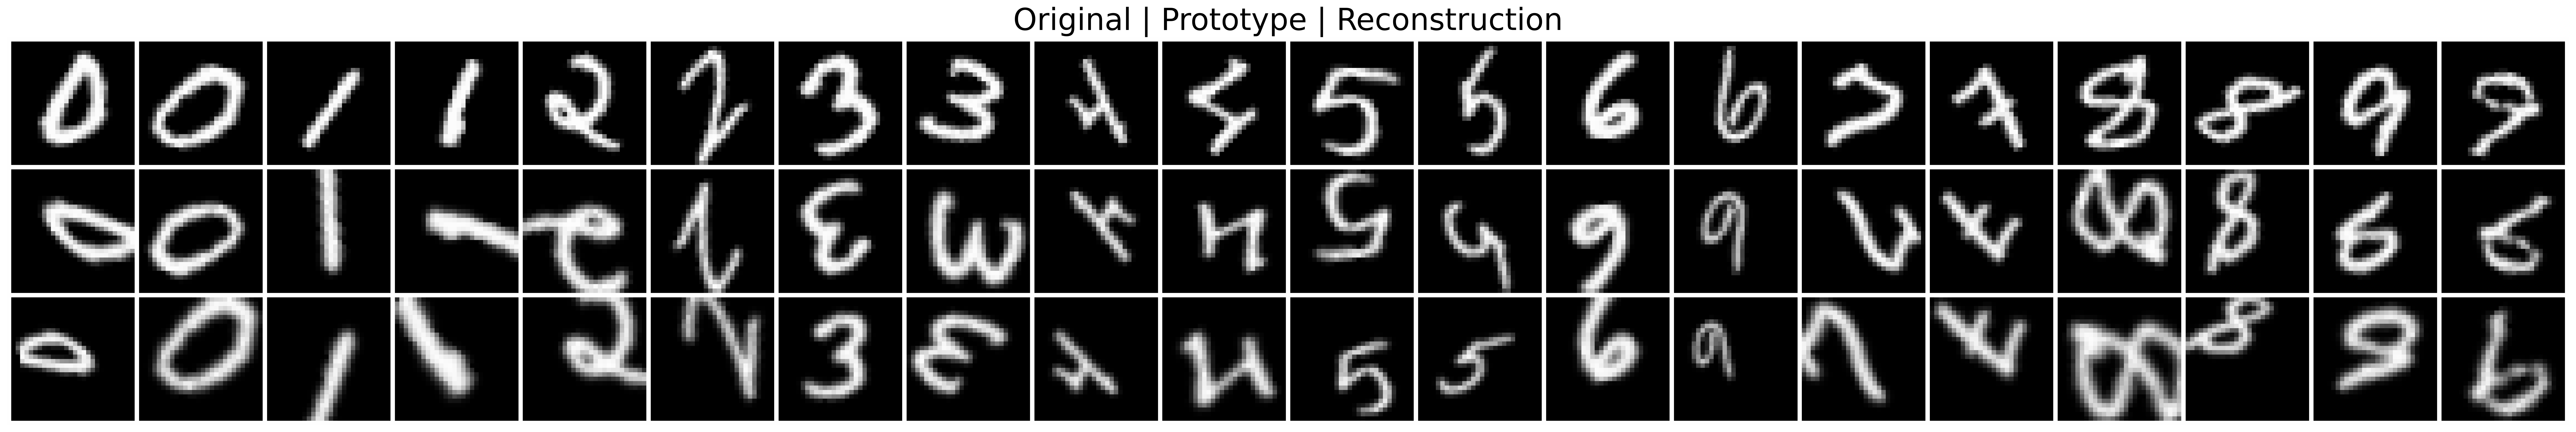

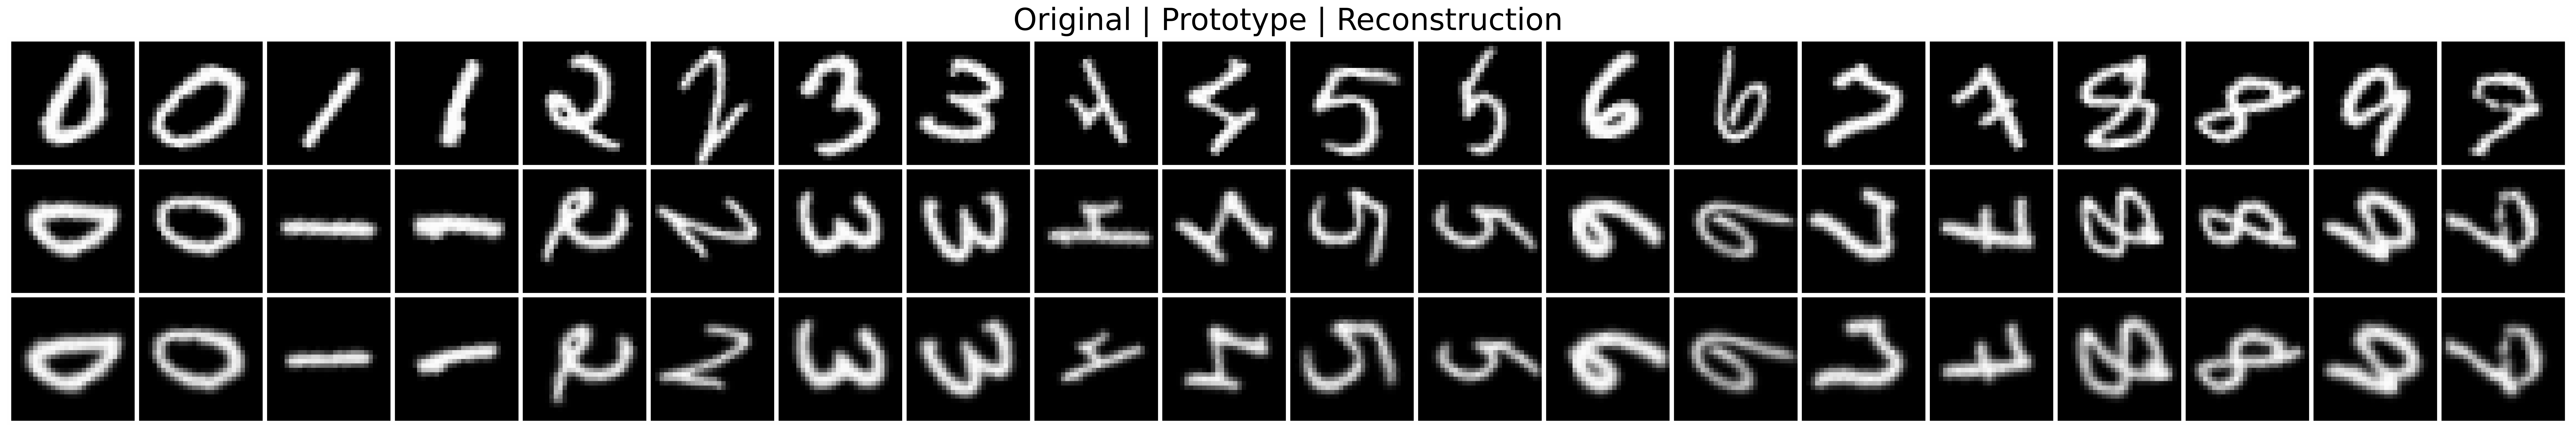

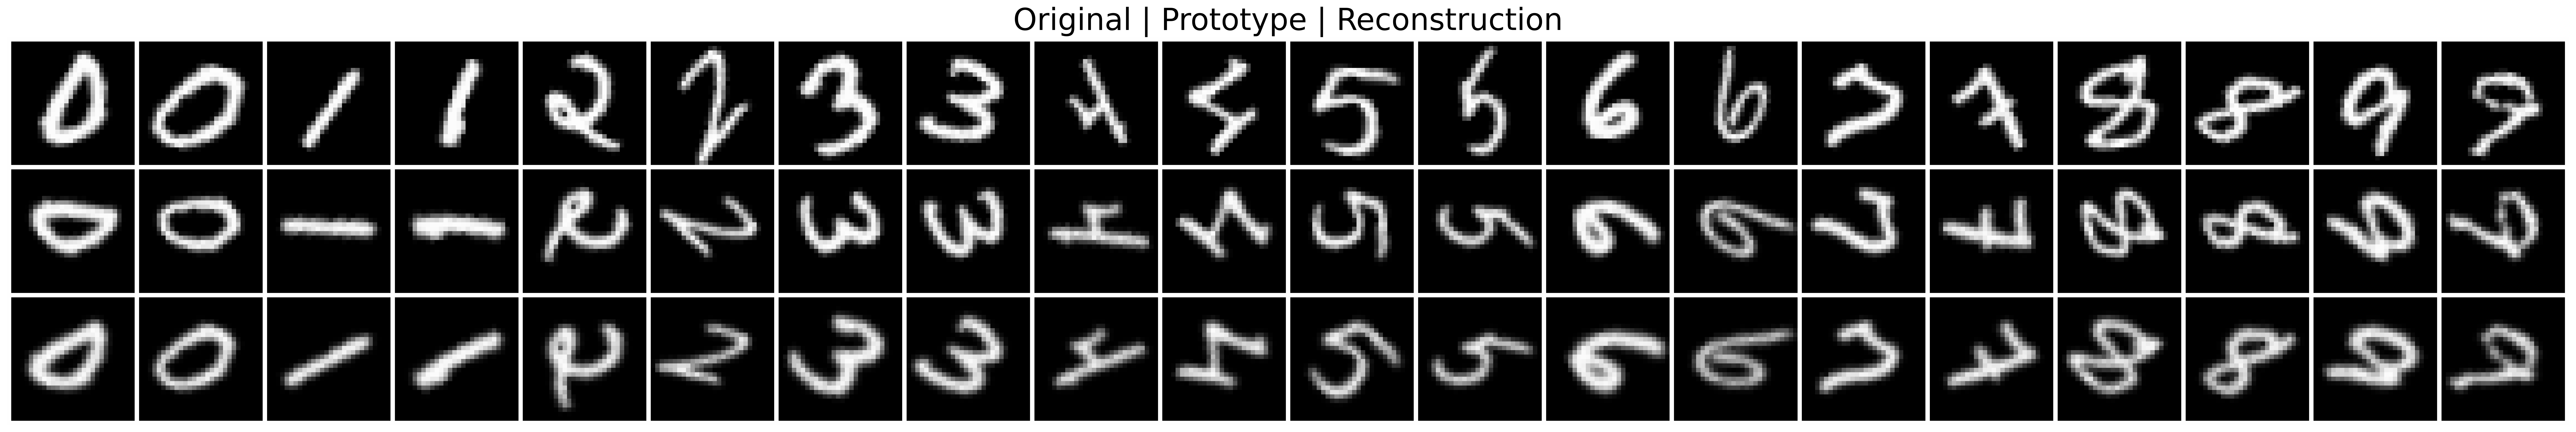

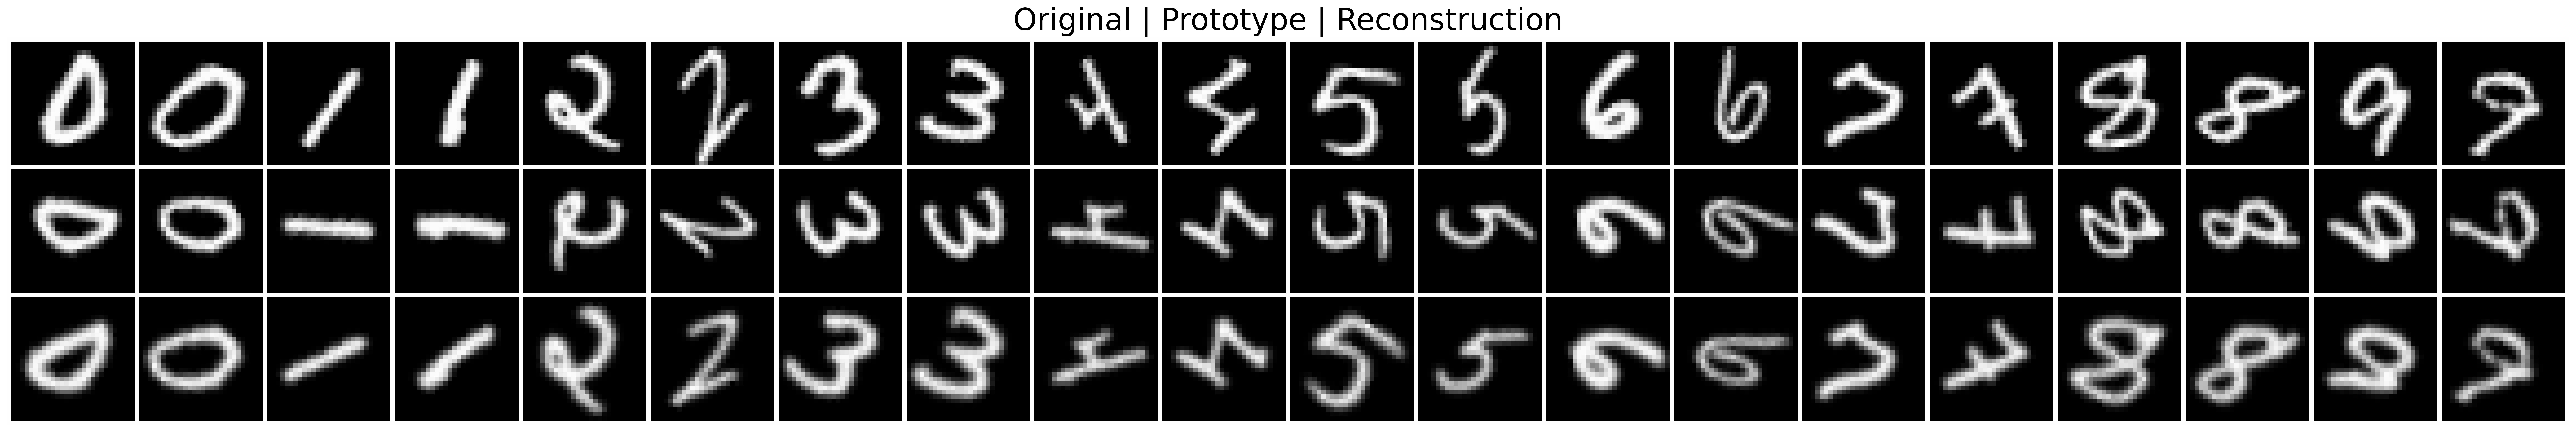

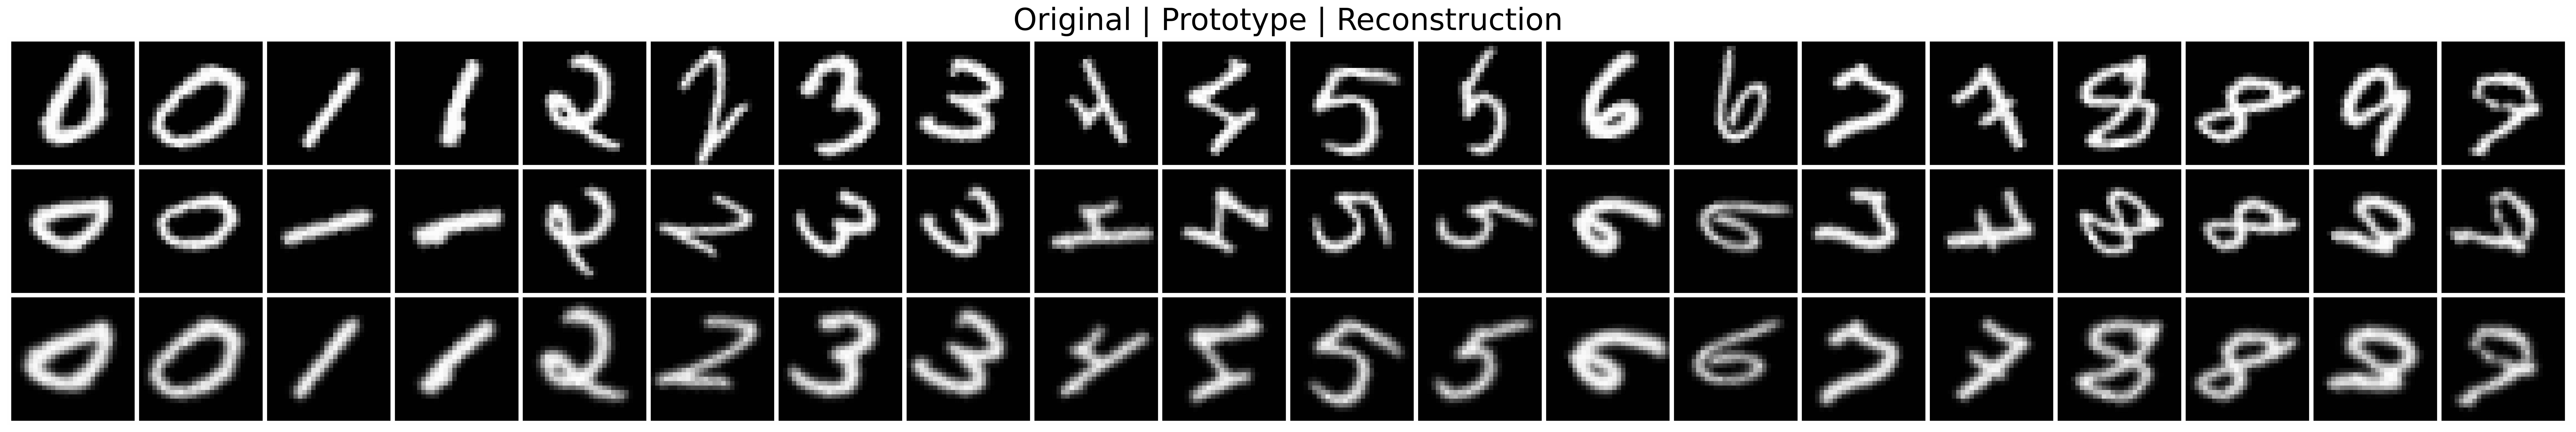

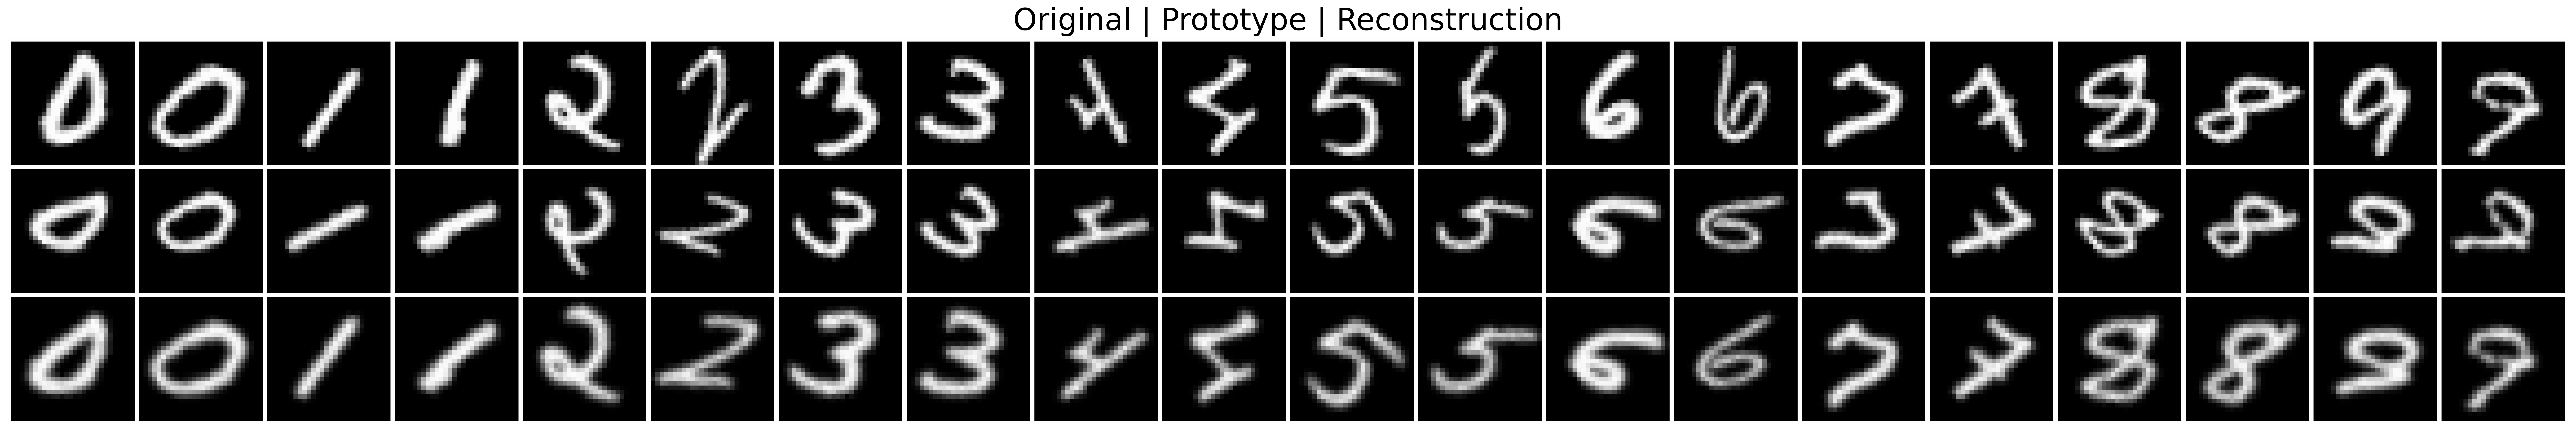

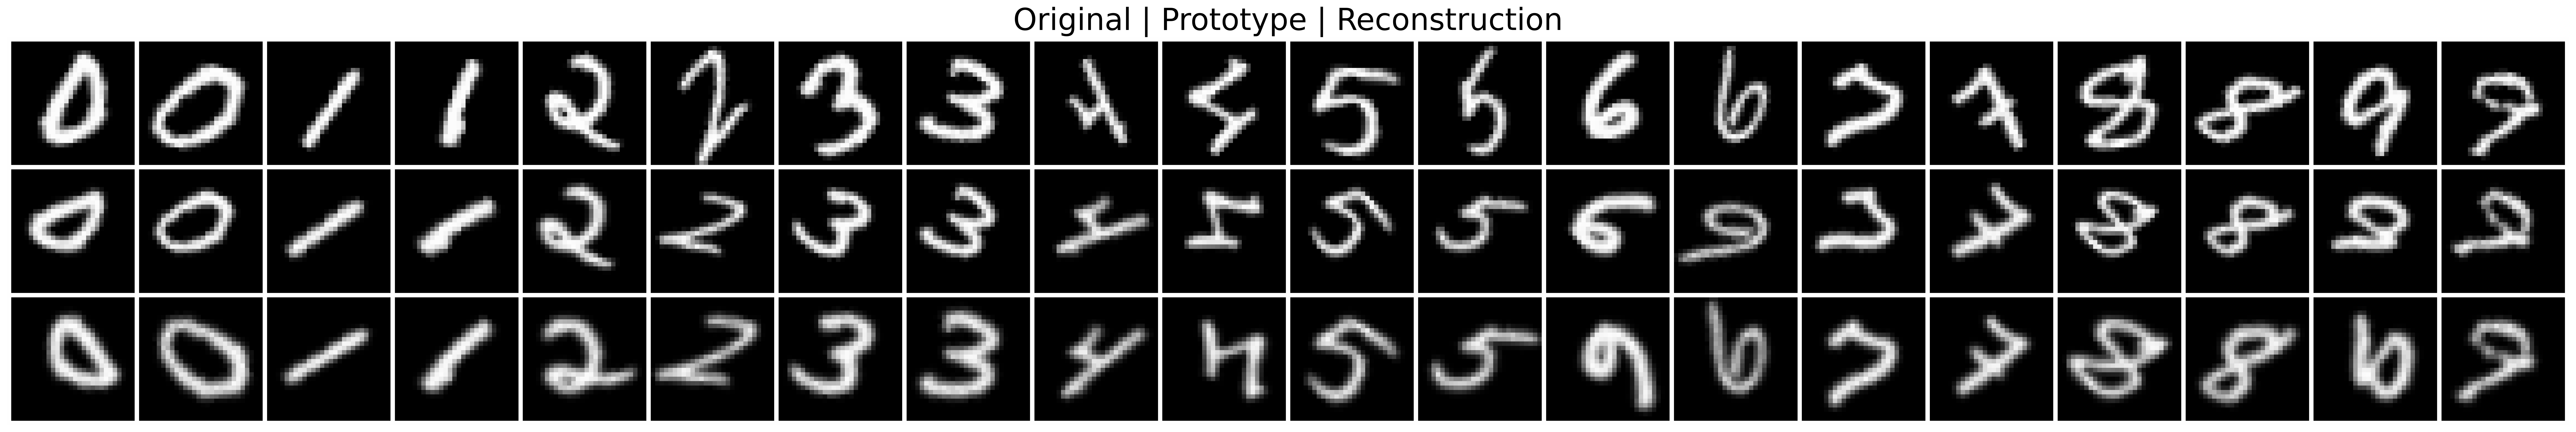

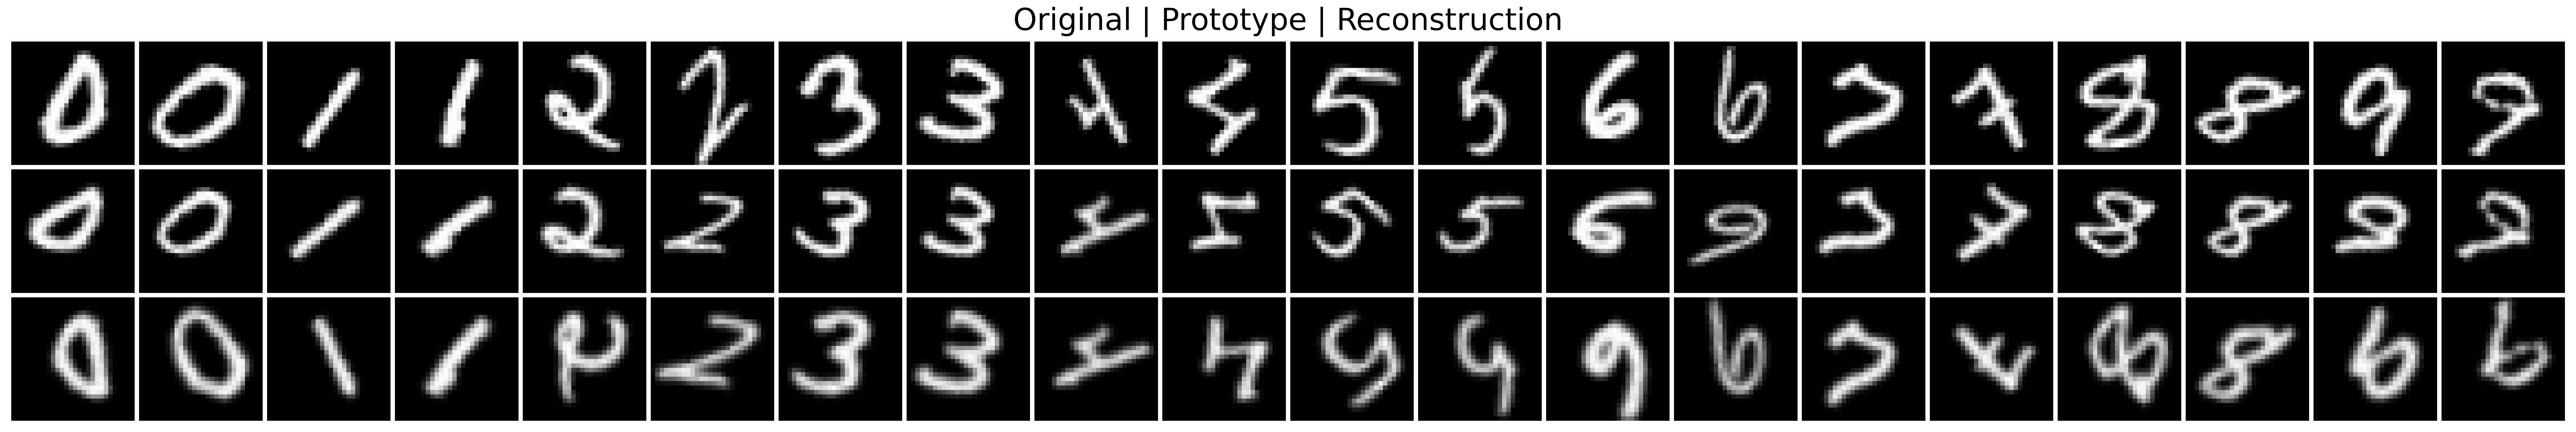

INFO:absl:Training finished.


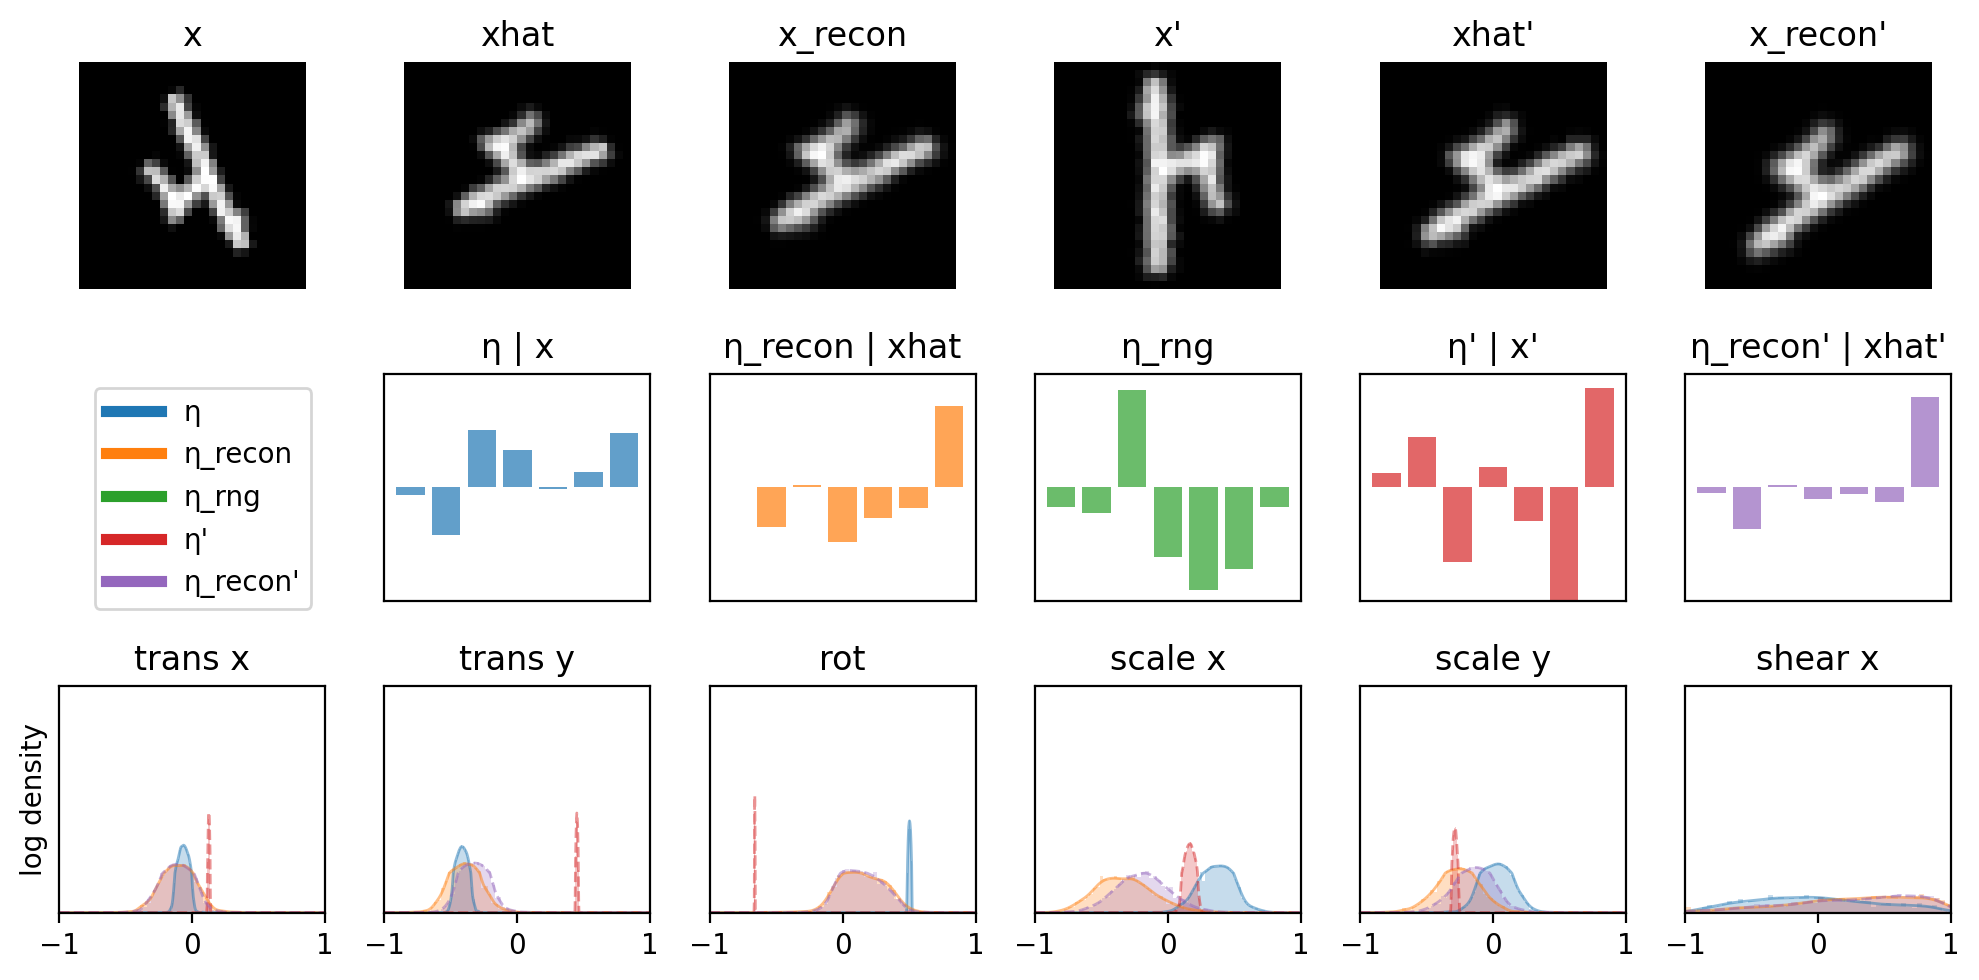

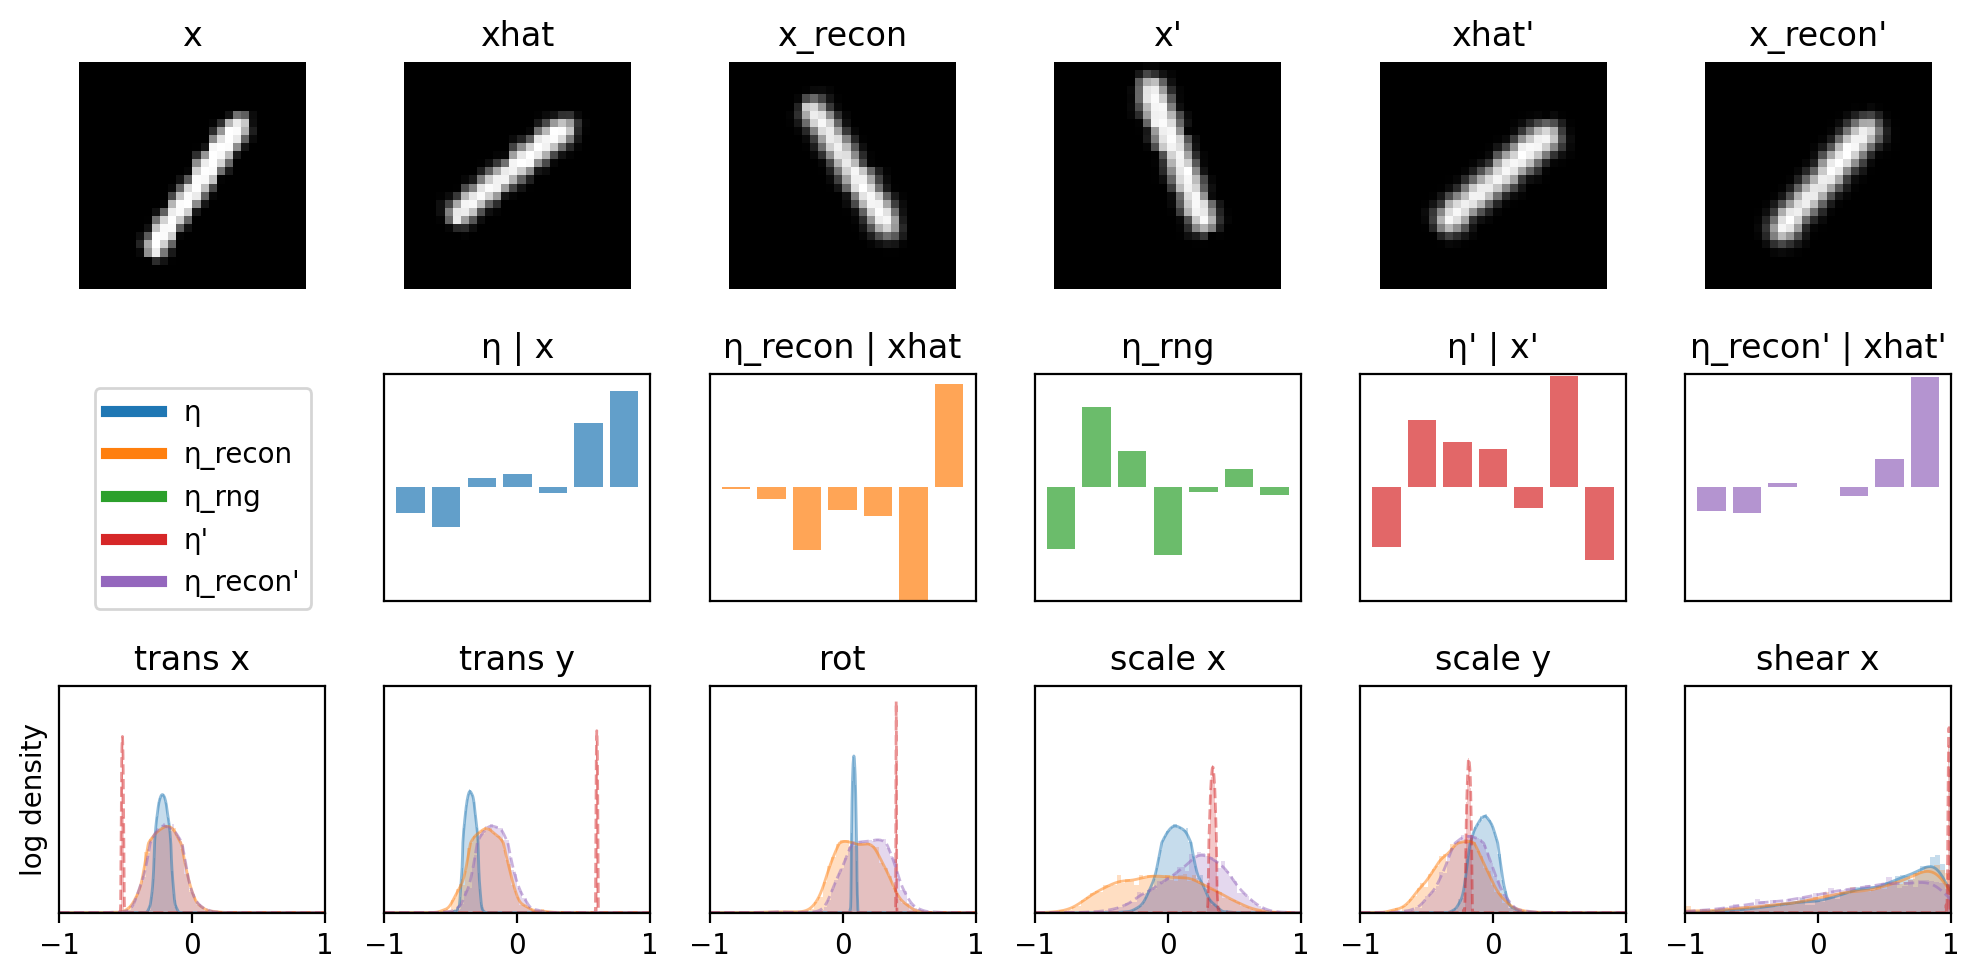

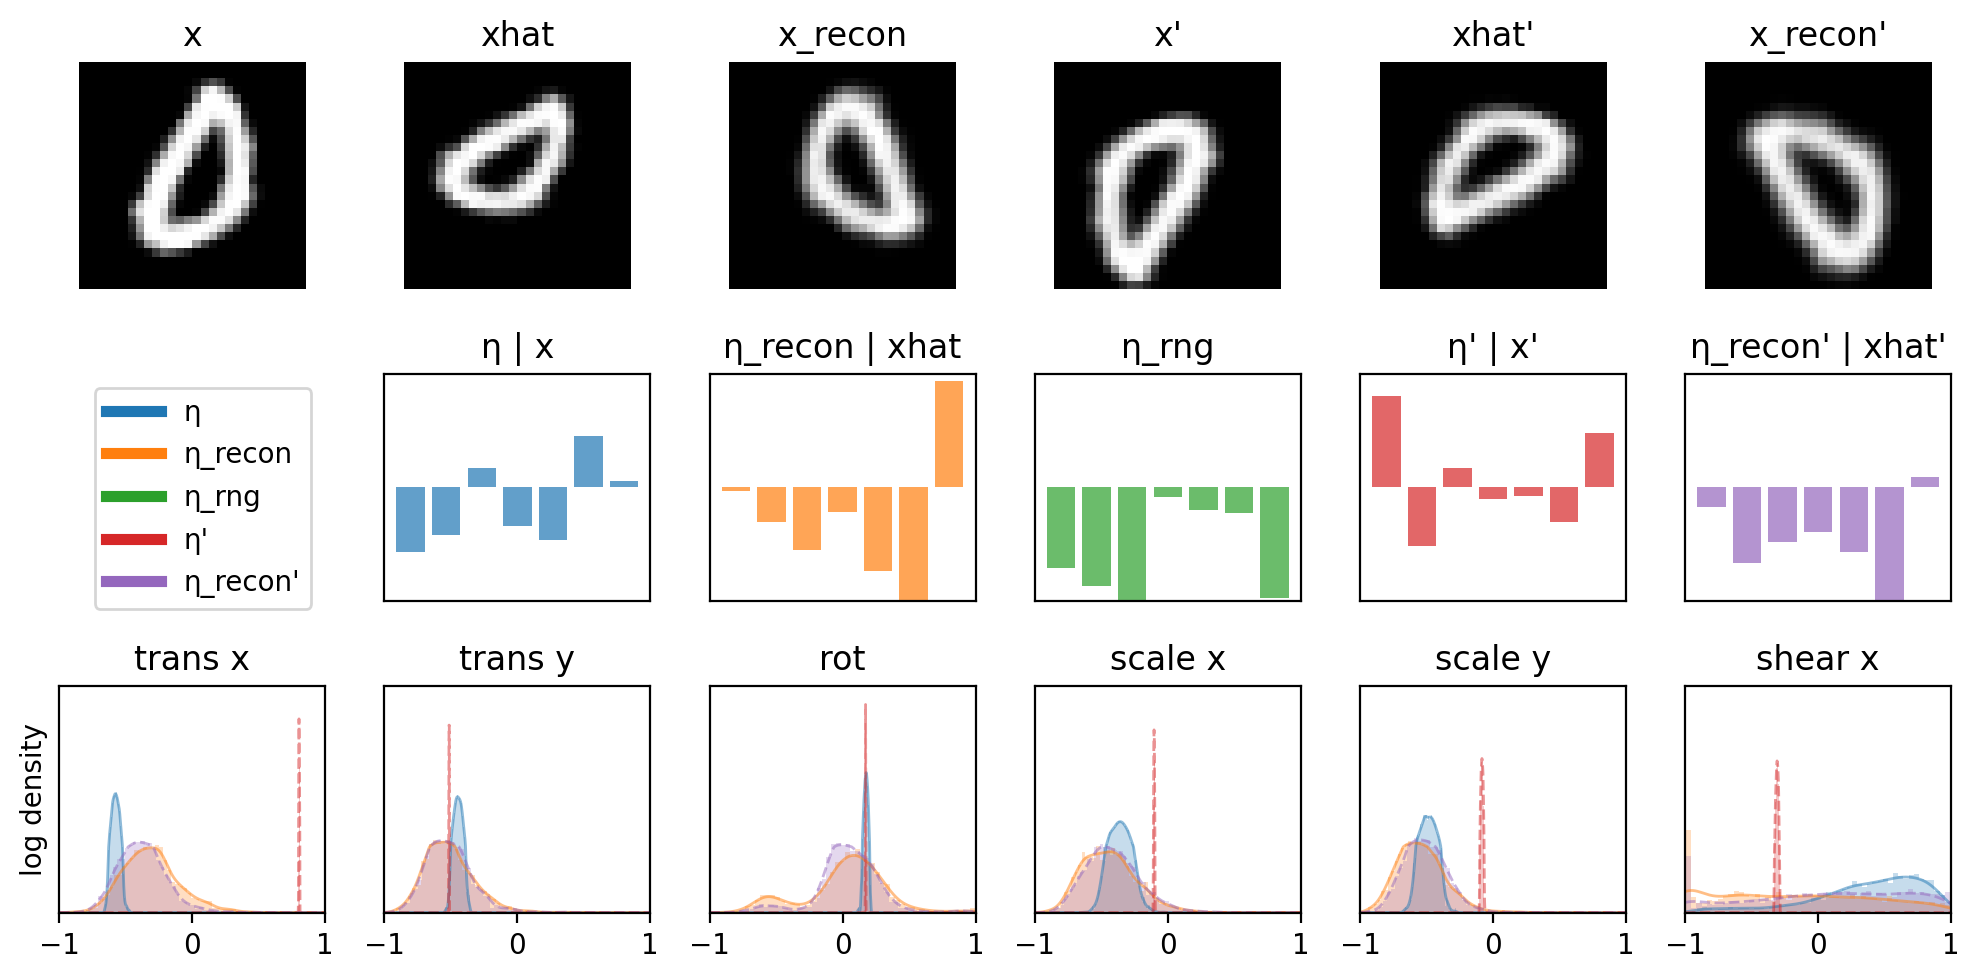

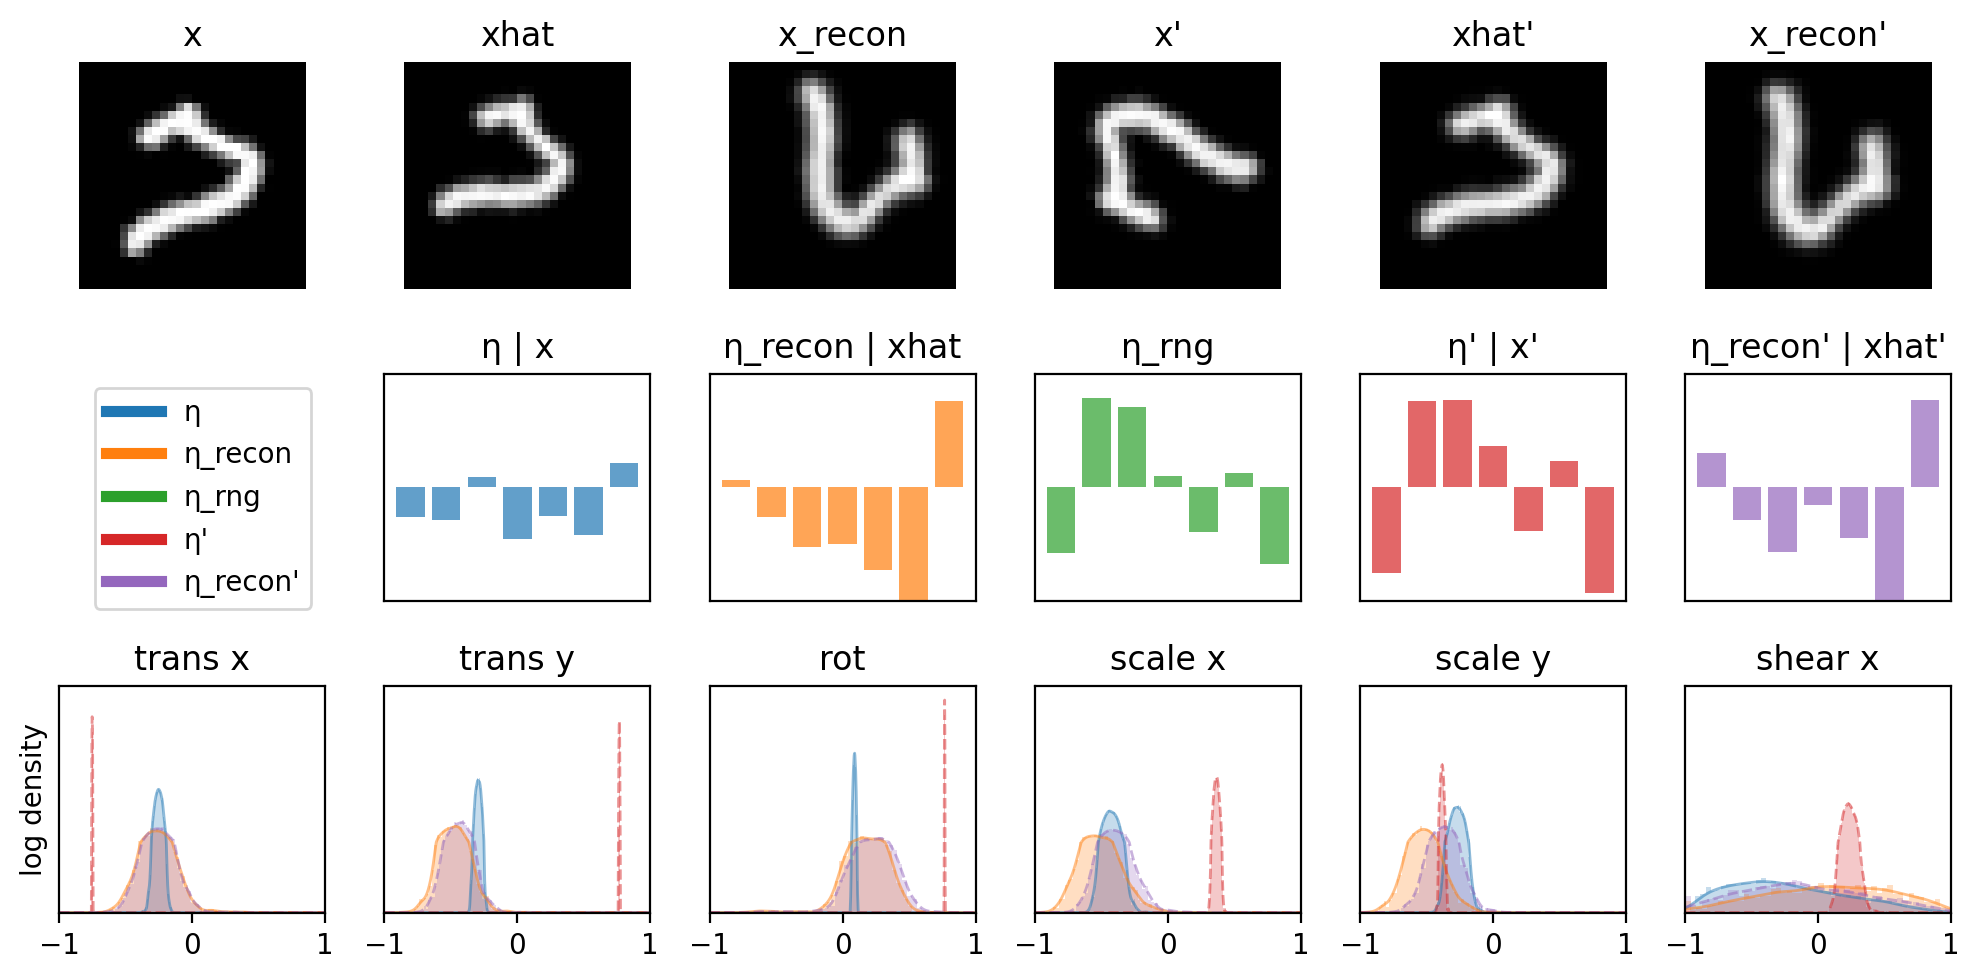

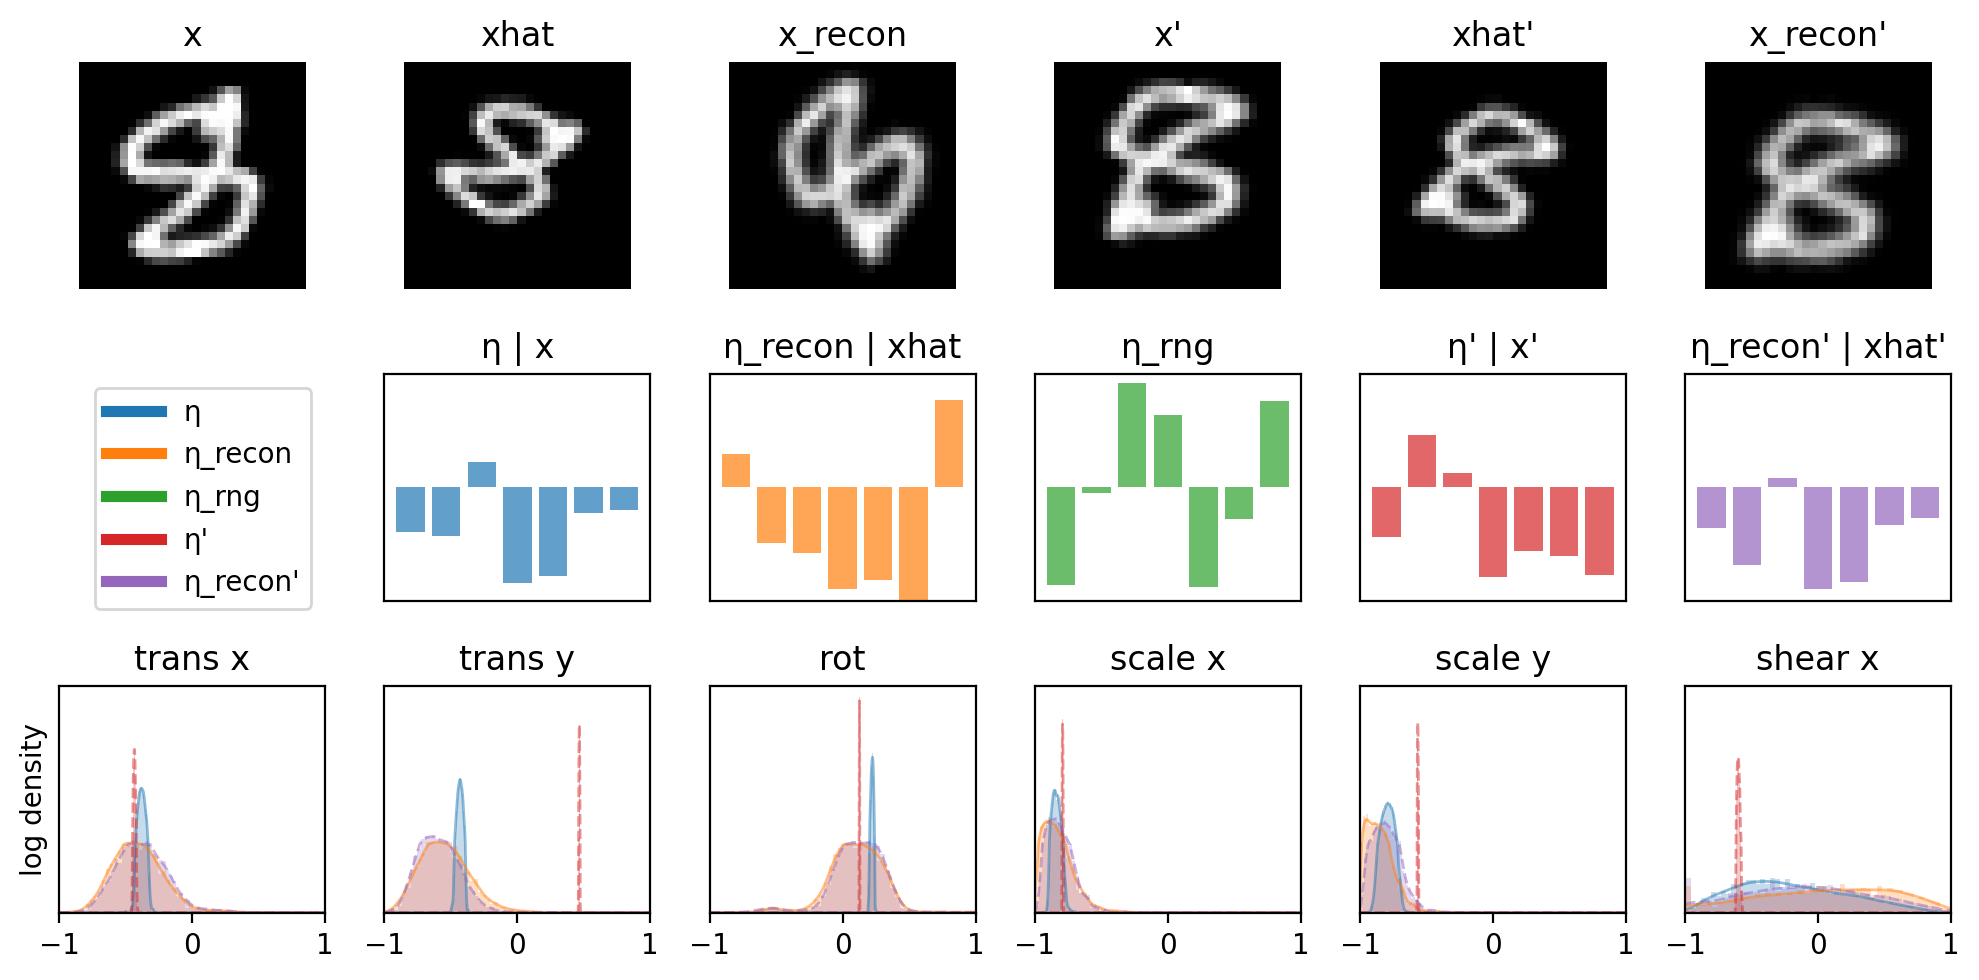

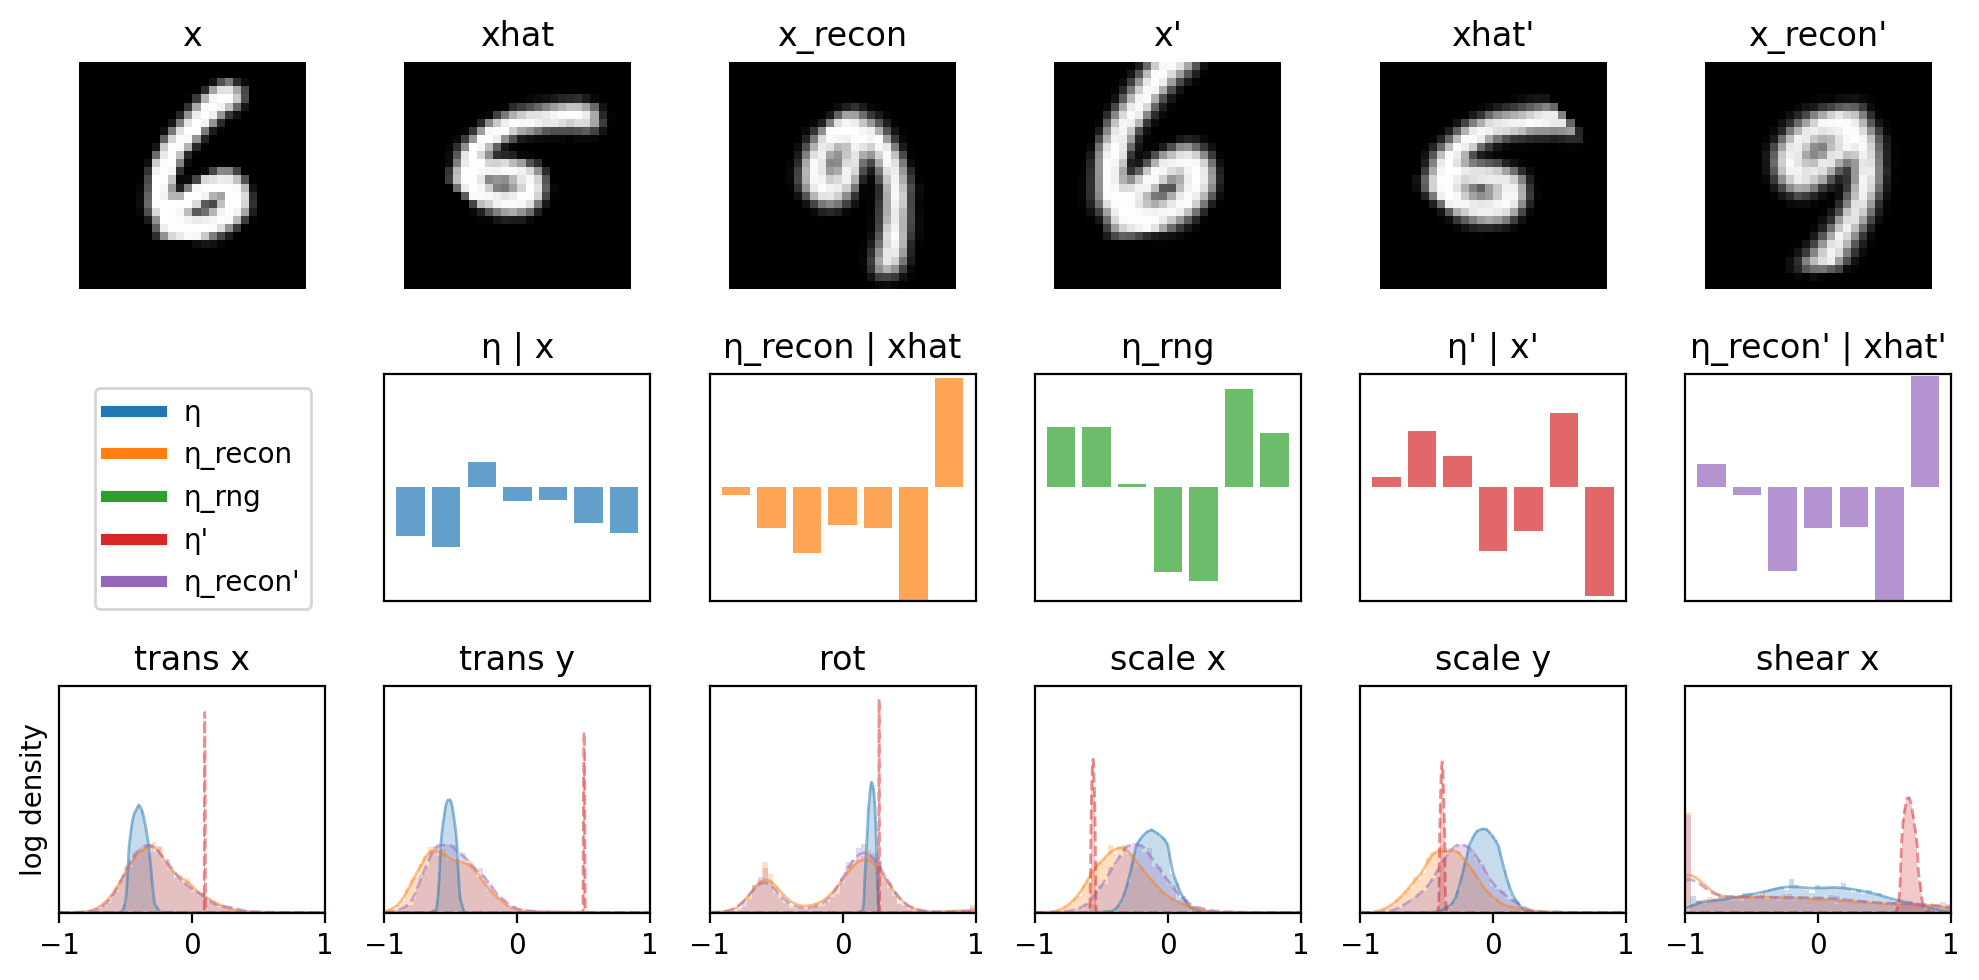

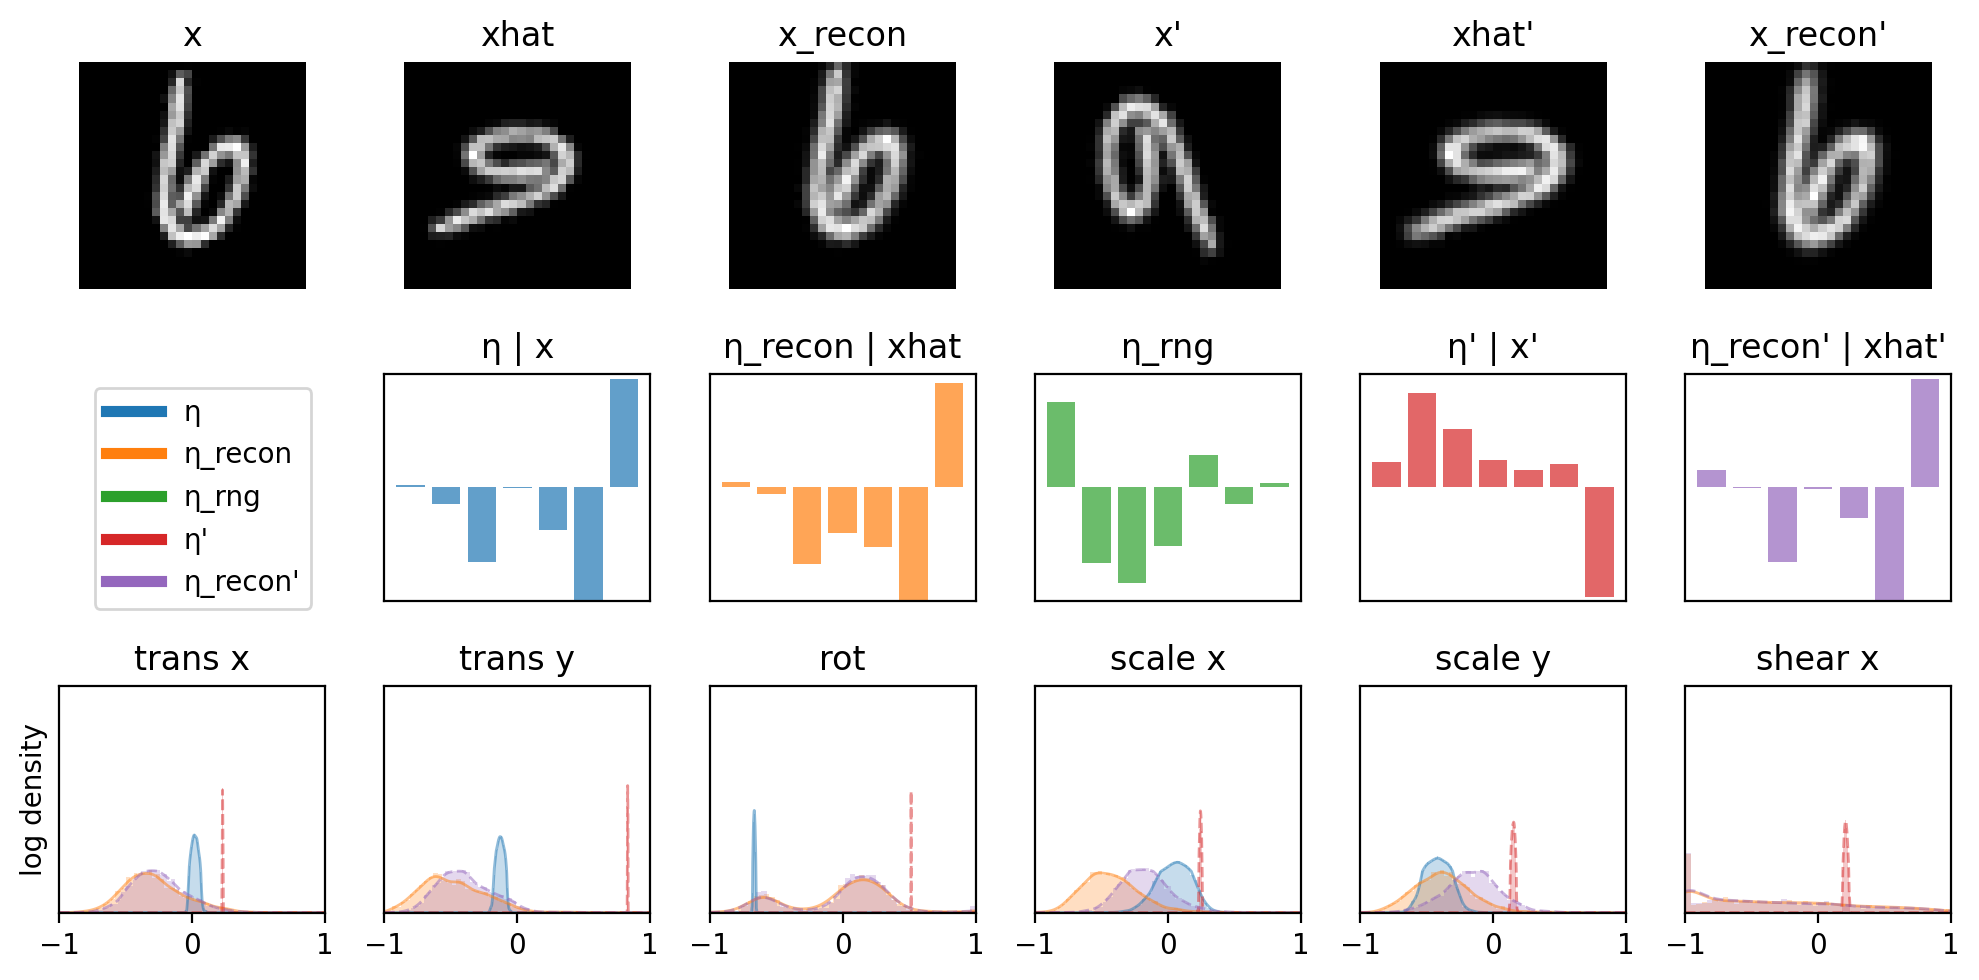

In [8]:
final_state = train_loop(
    config,
    model,
    state,
    train_ds,
    val_ds,
    wandb_kwargs={
        'mode': 'online',
        'tags': ['debug', '12-04-2023'], 
        'notes': (
            'Trying to make prototypes more identifiable, also standardised. '
            'γ schedule from 10. to 1. '
            'α schedule from 0.1 to 1. '
        )
    }
);

TODO: 
1. Try Javi's flow idea
2. Investigate the starred run in terms of 6 summary figs.

To try: 
1. ~~Start with small max transformations and then anneal to larger ones (only for the equivariance learning part?)~~
2. ~~Use more L2 norm - e.g. multiply by 10~~
3. Use L2 norm only once - e.g. on either p or q
4. Think about what kind of dataset to test on for this method to make sense. Maybe we want multiple rotated versions of each digit so that there are some non-unique prototypes?
5. ~~Make the NSF more powerful...~~ ResNet?
6. Add transformtion data augmentation to the flows.

In [9]:
if RUN_VERIFICATION:
    pass
else:
    raise RuntimeError("Set RUN_VERIFICATION to True to run verification.")

RuntimeError: Set RUN_VERIFICATION to True to run verification.

## Verify some shizzle

In [ ]:
from src.utils import input as input_utils
from src.models.ssil import make_summary_plot
from src.transformations.affine import transform_image
from src.models.common import (
    Flow,
    approximate_mode,
)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
import jax
import distrax


summary_rng = random.PRNGKey(0)

[autoreload of src.utils.training failed: Traceback (most recent call last):
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


In [ ]:
val_iter = input_utils.start_input_pipeline(val_ds, config.get("prefetch_to_device", 1))
val_batch = next(val_iter)
# x = val_batch['image'][0][4]
# plt.imshow(x, cmap='gray')

### Make plot

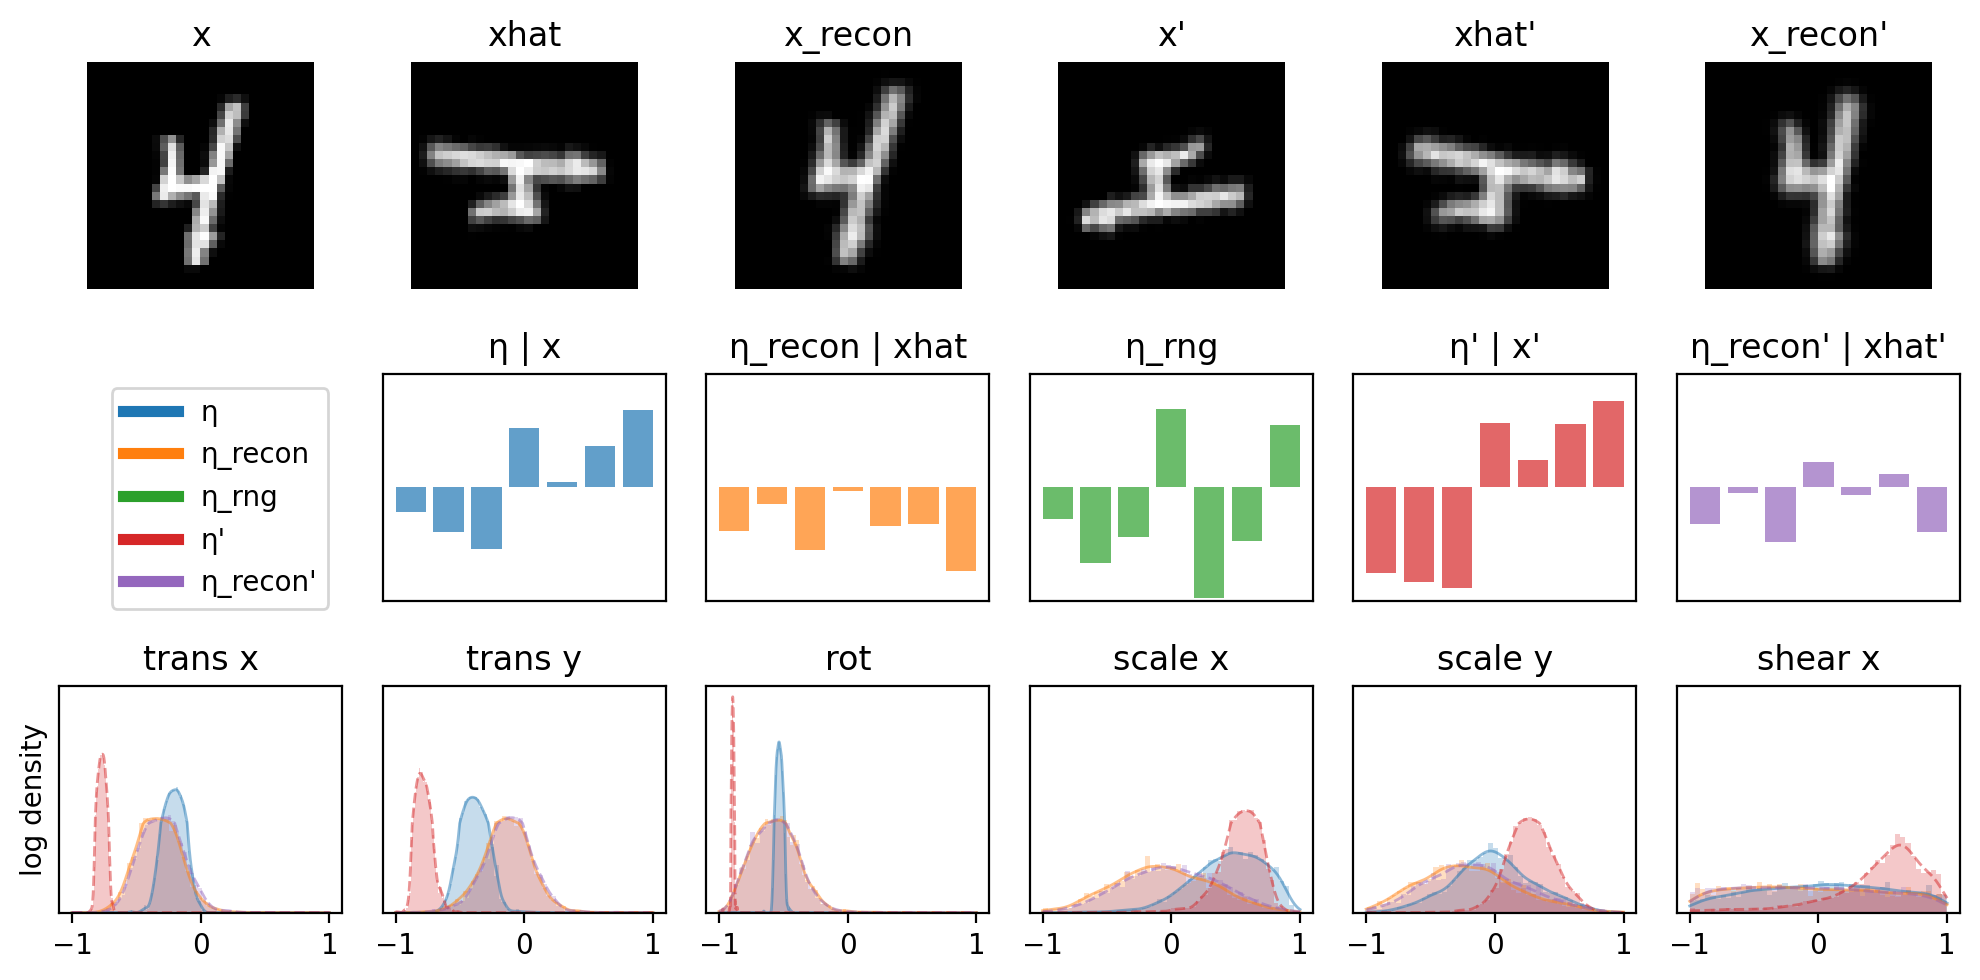

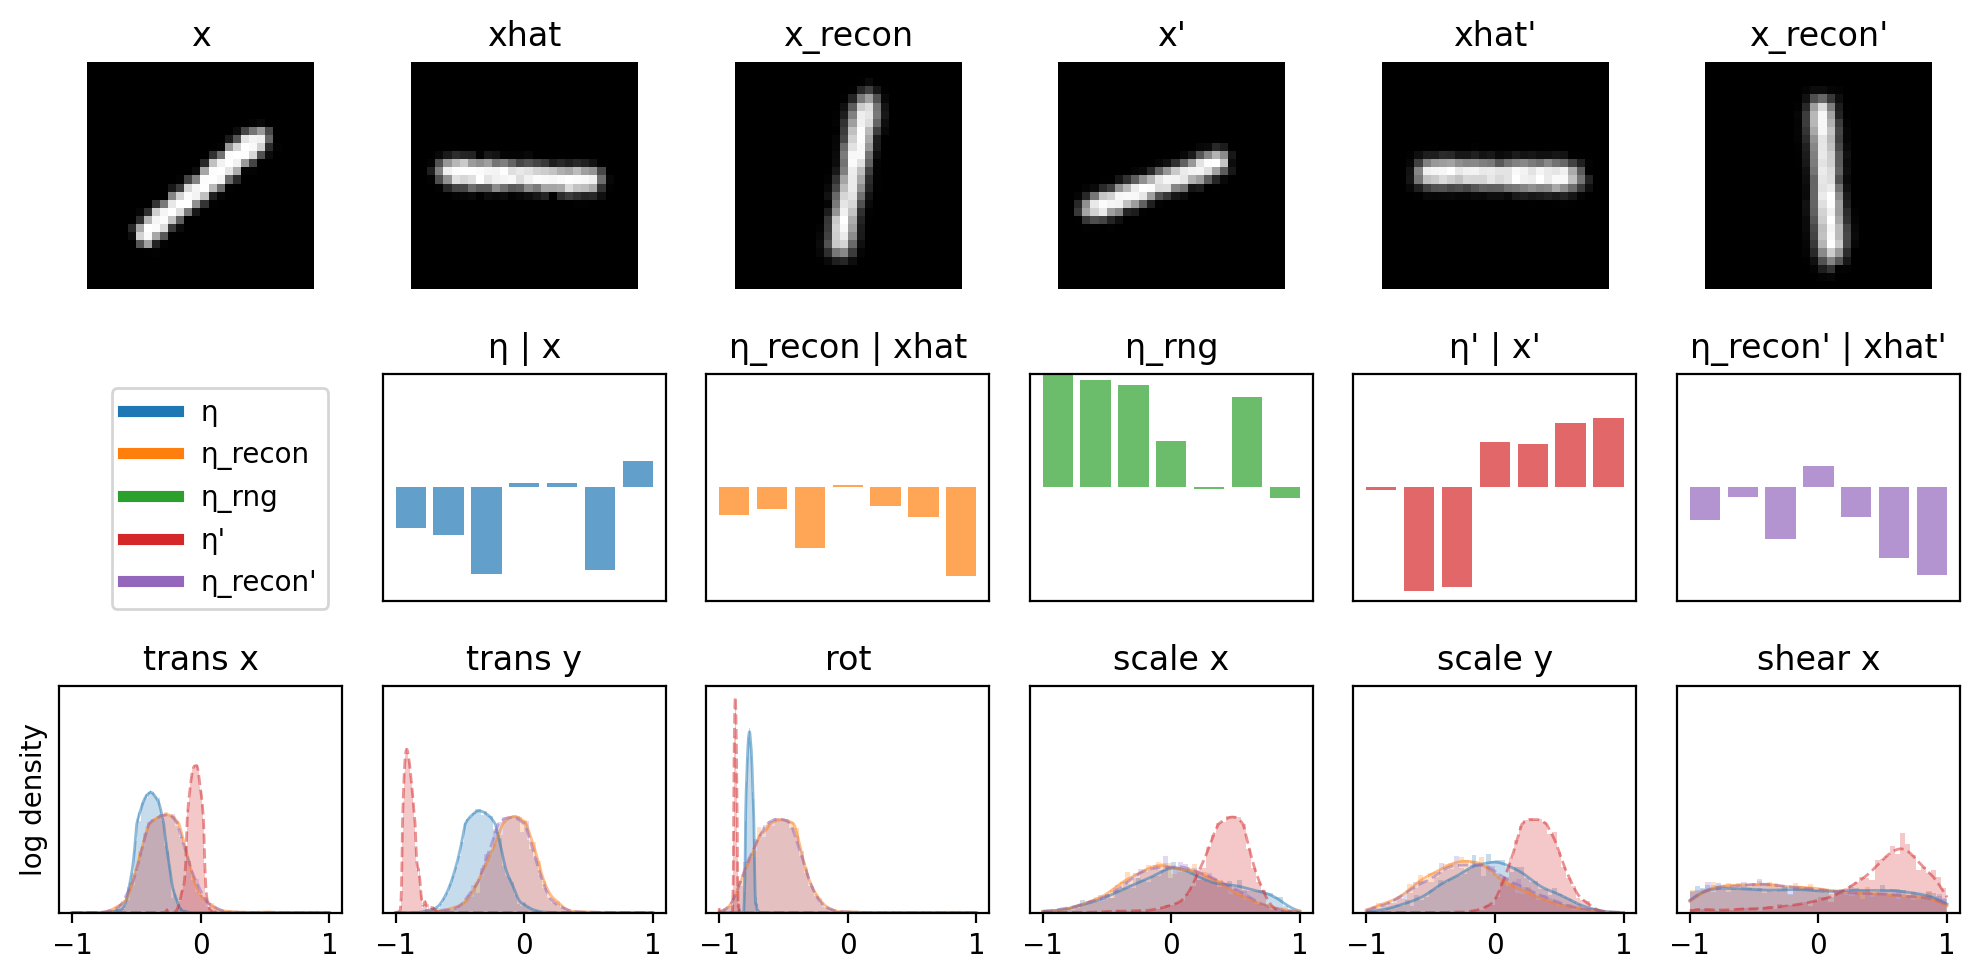

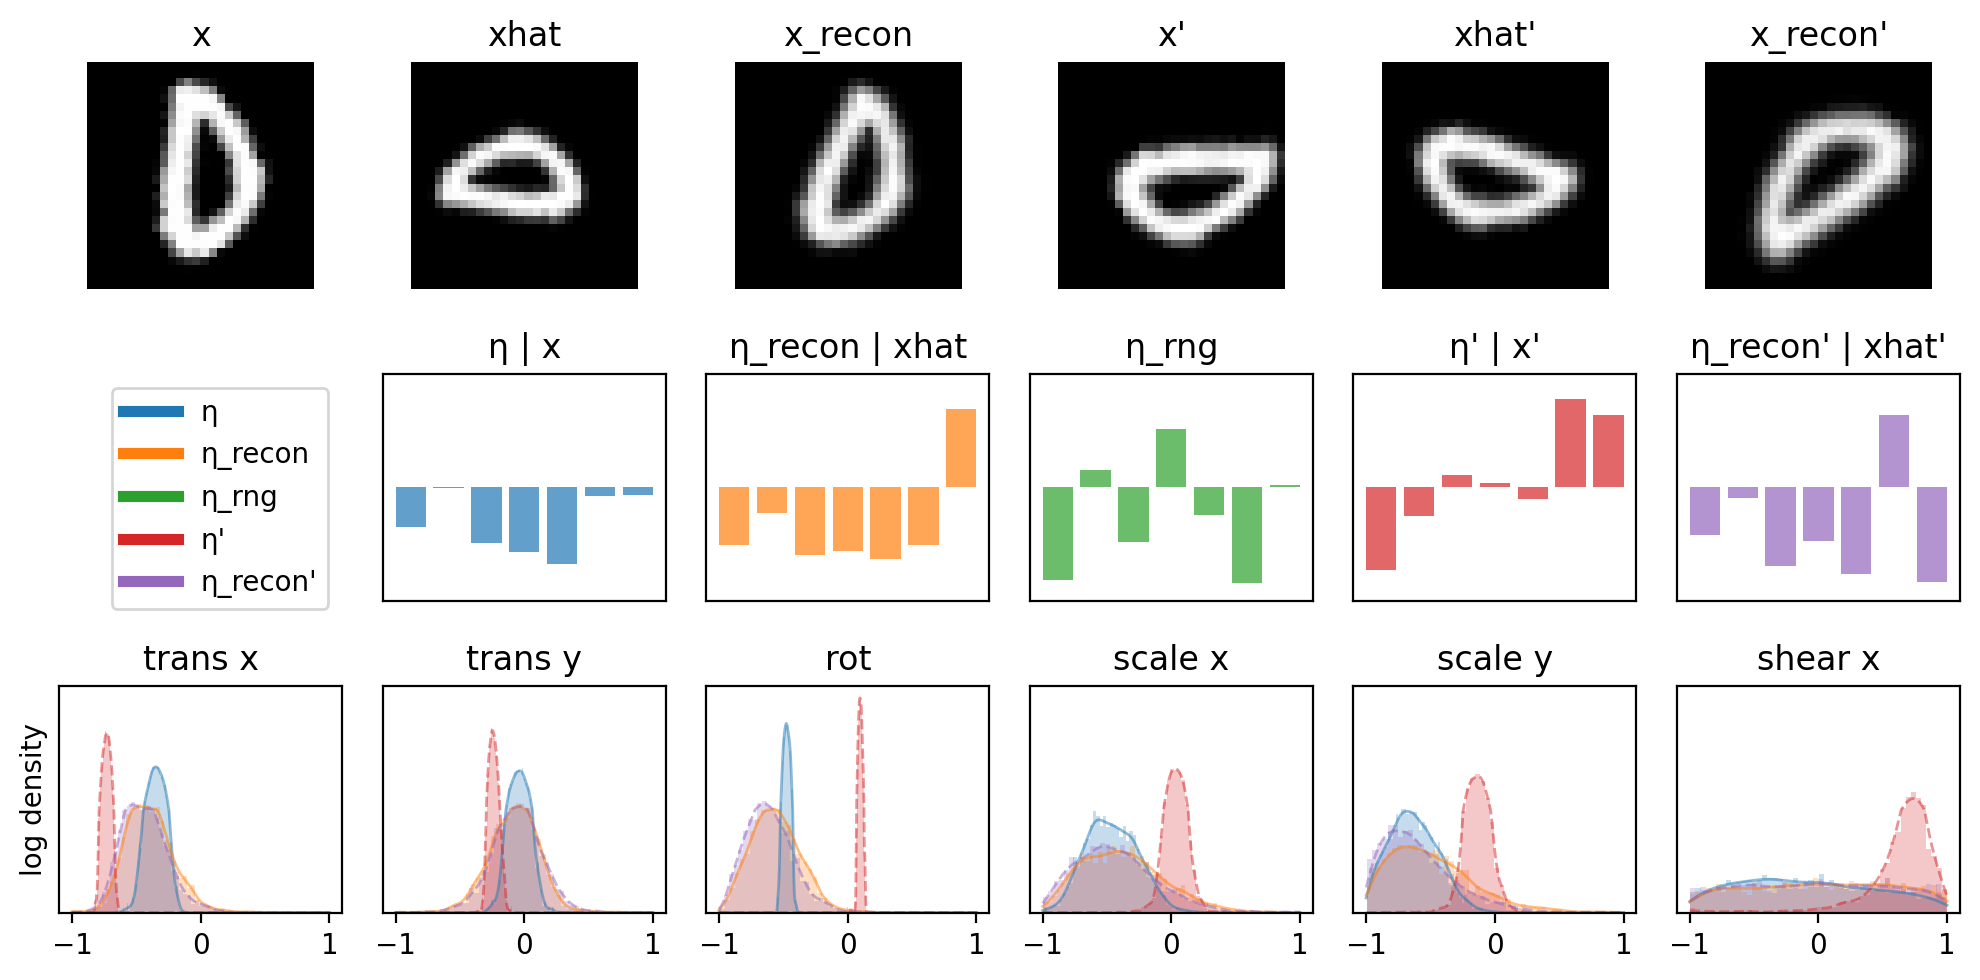

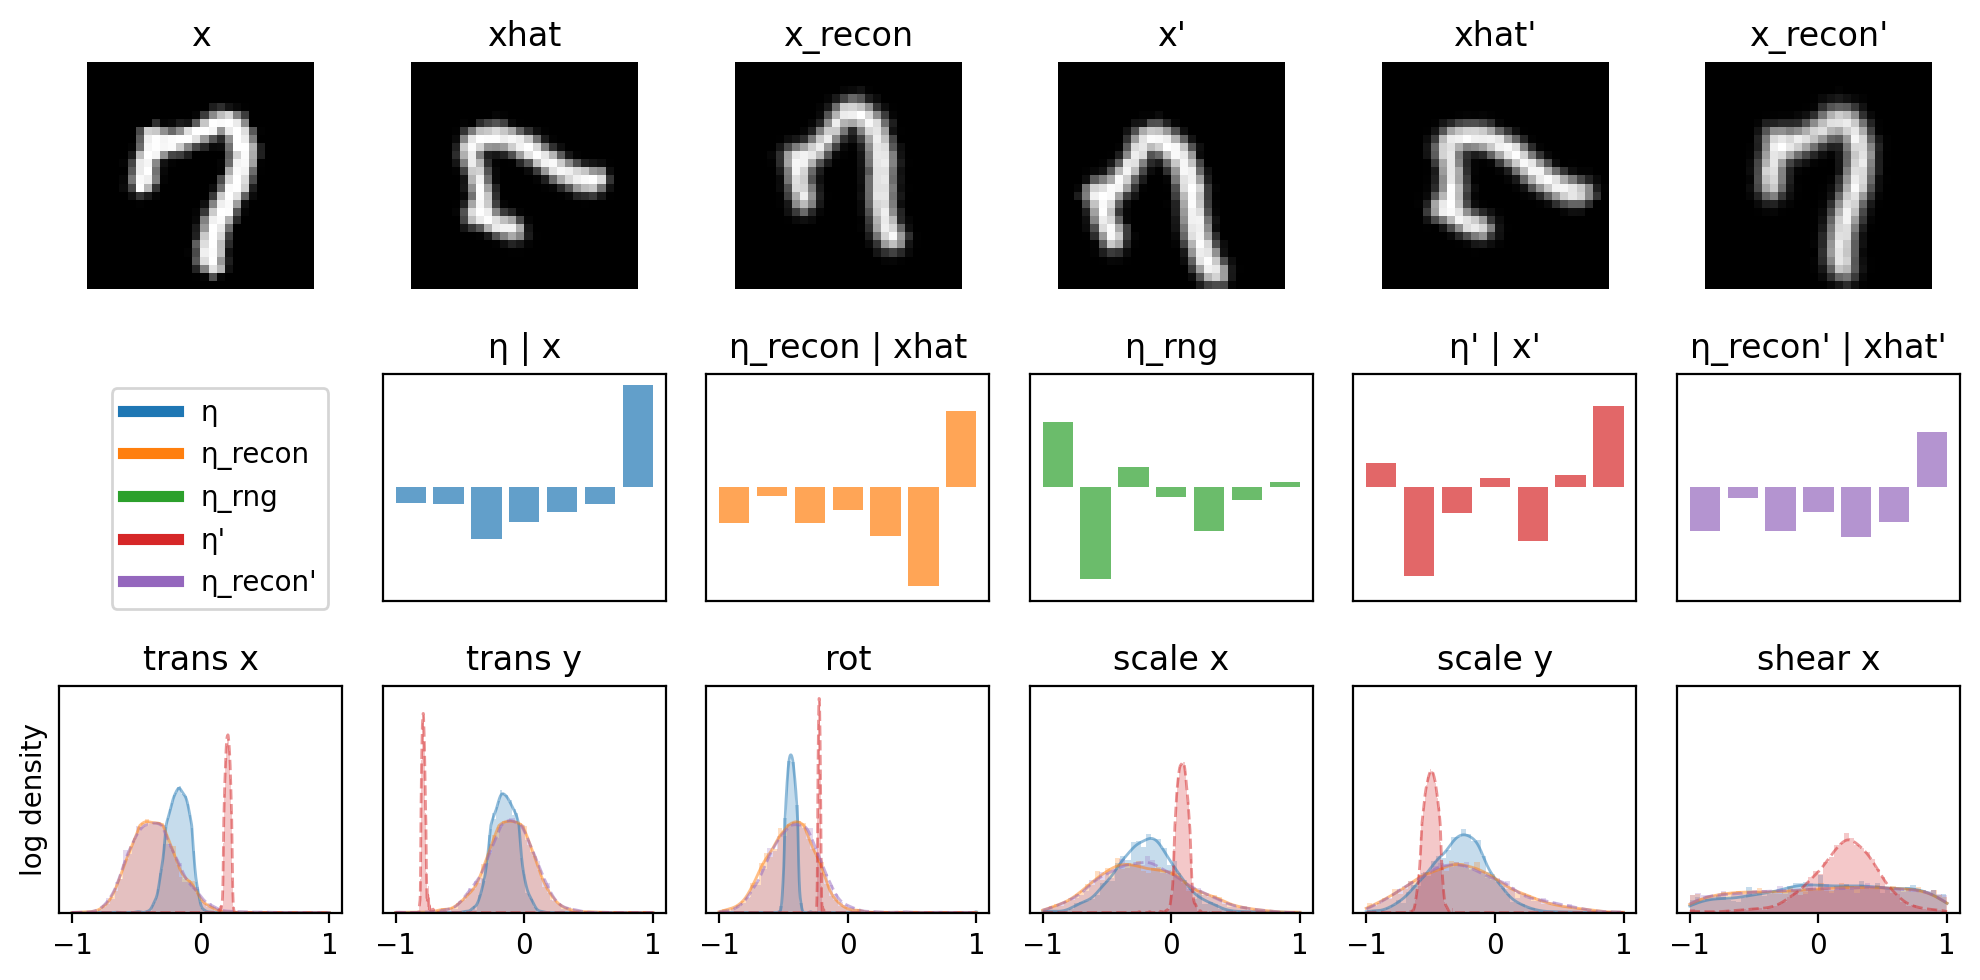

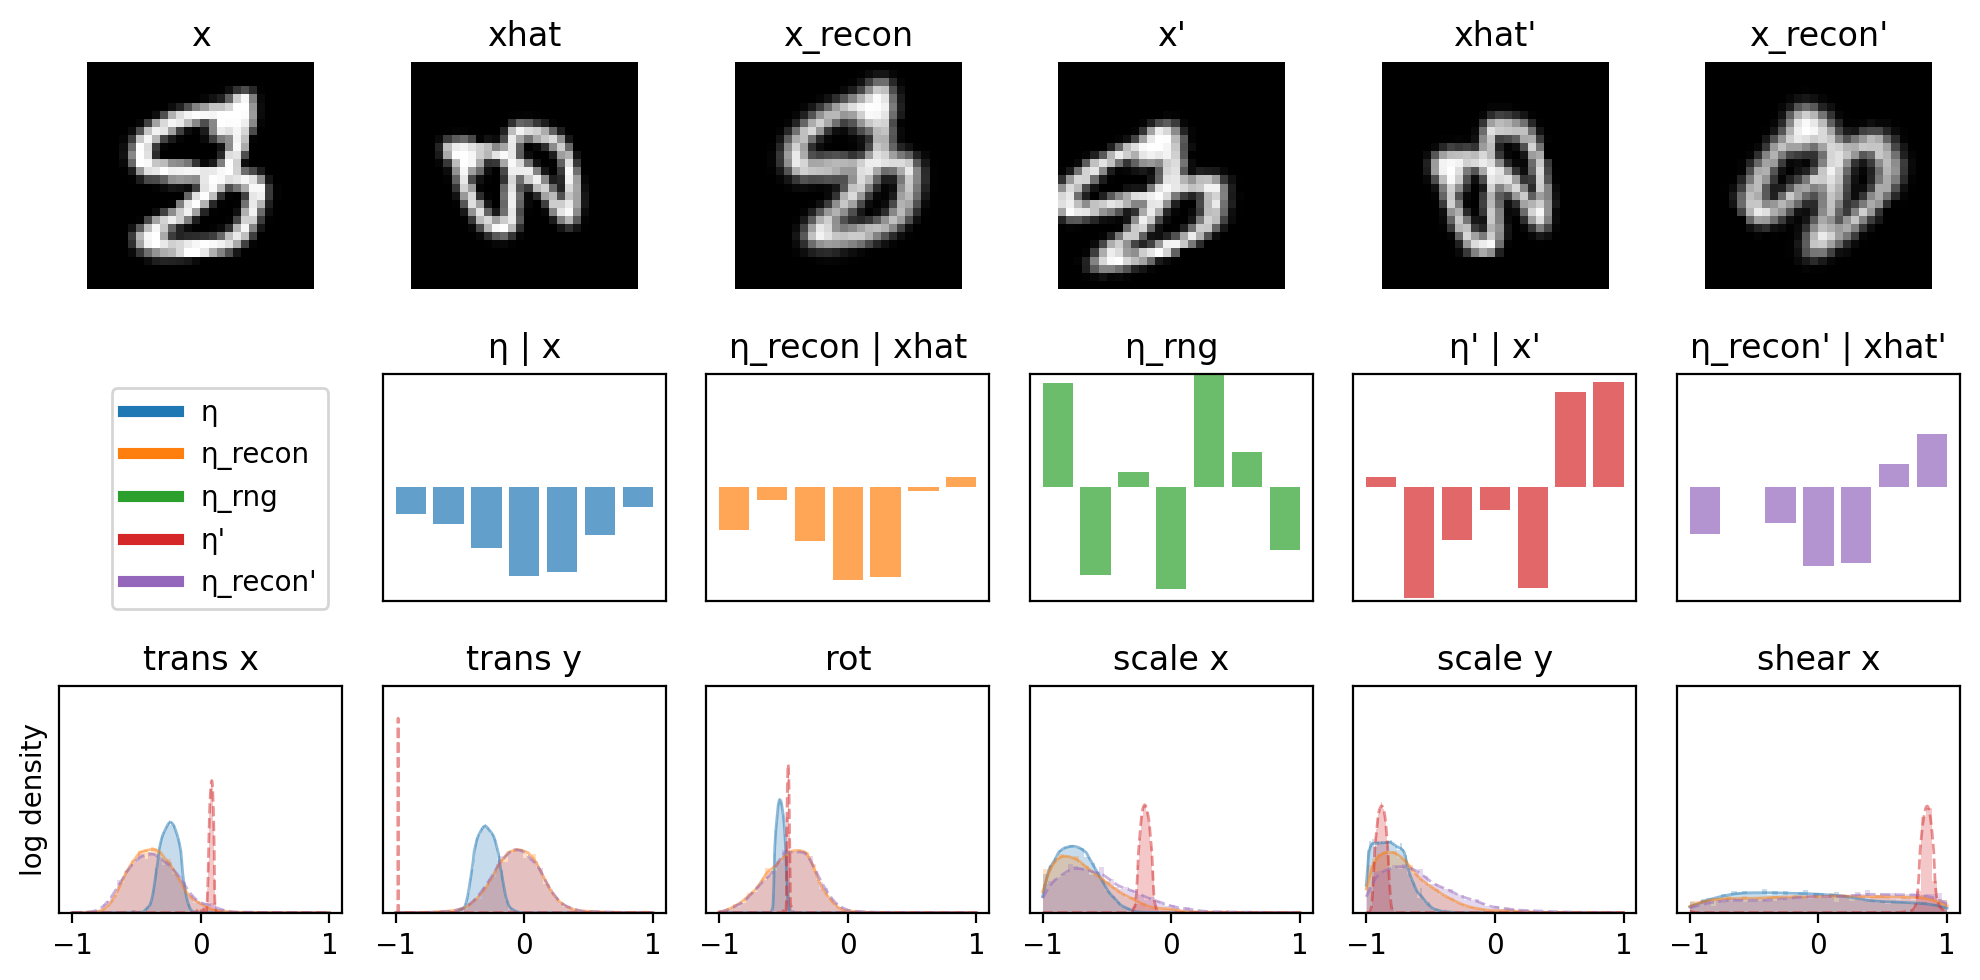

In [ ]:
for i, x in enumerate(val_batch['image'][0][:5]):
    tmp_rng, summary_rng = jax.random.split(summary_rng)
    make_summary_plot(config, final_state, x, tmp_rng)

It seems that the prototypes are not invariant at the moment. Strangely, when using the same RNG key for both η | x and η' | x', the prototypes end up being the same. This indicates that the distribution is independent of the input. This is confirmed when lookinh at the η_recon distributions, which are identical for different digits :(.

### Investigate Distributions

In [ ]:
def make_dist_plots(dist, rng, color='C0'):
    samples, _ = dist.sample_and_log_prob(seed=rng, sample_shape=(3000,))
    samples = samples / jnp.array(config.model.bounds)
    _, num_dims = samples.shape

    fig, axs = plt.subplots(1, num_dims, figsize=(20, 4), dpi=400, sharey=True)

    for i in range(num_dims):
        axs[i].hist(samples[:, i], bins=50, density=True, color=color, alpha=0.5)
        # plot a gaussian KDE over the histogram
        x = jnp.linspace(-1, 1, 1000)
        kde = gaussian_kde(samples[:, i])
        axs[i].plot(x, kde(x), color=color)

    fig.tight_layout()
    fig.show()


In [ ]:
η, η_, p_X_given_xhat_and_η, p_Η_given_xhat, q_Η_given_x = model.apply(
    {"params": final_state.params},
    x,
    rng,
    1.0,
    train=False
)


In [ ]:
final_state.params['σ_']

ShardedDeviceArray(0.38065583, dtype=float32)

In [ ]:
p_X_given_xhat_and_η.log_prob(x)

DeviceArray(-752.90405, dtype=float32)

-673.692


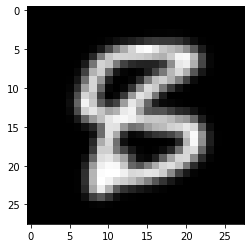

In [ ]:
x_rot = transform_image(x, jnp.array([0, 0, jnp.pi, 0, 0, 0, 0]))
plt.imshow(x_rot, cmap='gray')
print(p_X_given_xhat_and_η.log_prob(x_rot))

-786.0011


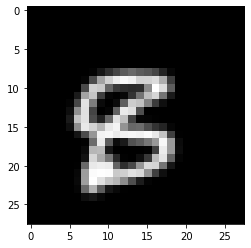

In [ ]:
x_trans = transform_image(x, jnp.array([0.25, 0.25, jnp.pi, 0.25, 0.25, 0, 0]))
plt.imshow(x_trans, cmap='gray')
print(p_X_given_xhat_and_η.log_prob(x_trans))

In [ ]:
η = approximate_mode(q_Η_given_x, 100, rng)
η

DeviceArray([-0.05048791, -0.07518937, -1.6429071 , -0.18842126,
             -0.2245992 , -0.01341782,  0.00817552], dtype=float32)

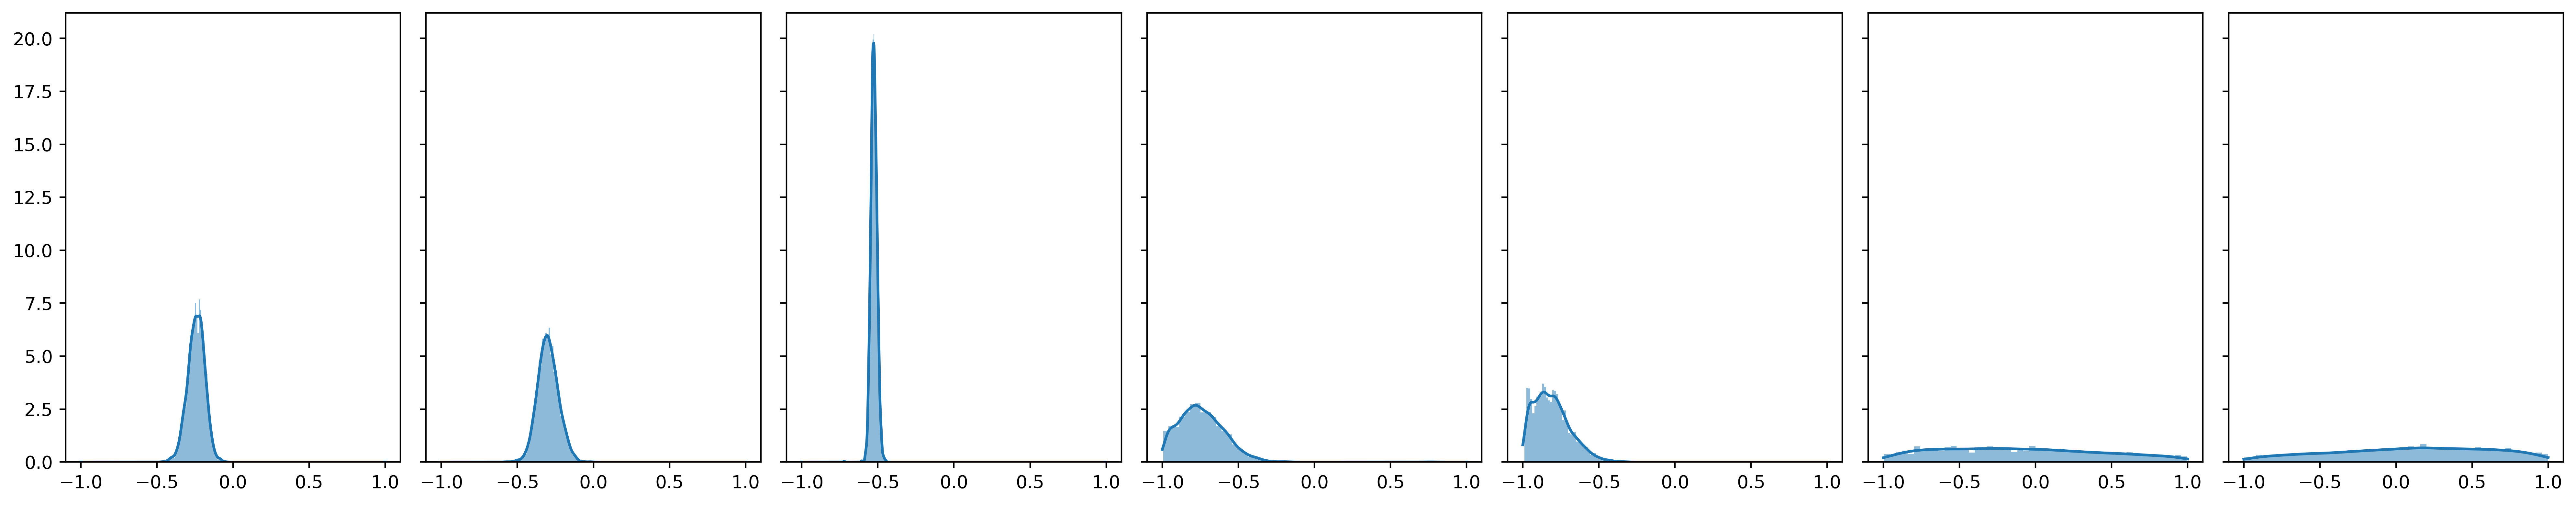

In [ ]:
make_dist_plots(q_Η_given_x, rng)

In [ ]:
q_Η_given_x.log_prob(η)

DeviceArray(18.315418, dtype=float32)

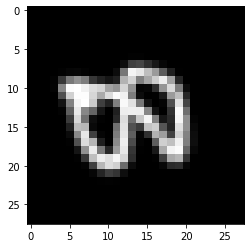

In [ ]:
x_hat = transform_image(x, -η)
plt.imshow(x_hat, cmap='gray')

In [ ]:
η2 = approximate_mode(p_Η_given_xhat, 1000, rng)
η2

DeviceArray([-0.11624698, -0.03274662, -1.7531292 , -0.24303898,
             -0.20750642,  0.02477482, -0.02615862], dtype=float32)

In [ ]:
p_Η_given_xhat.log_prob(η2)

DeviceArray(13.689987, dtype=float32)

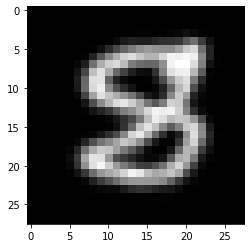

In [ ]:
x_rec = transform_image(x_hat, η2)
plt.imshow(x_rec, cmap='gray')

In [ ]:
q_Η_given_x.event_shape

JaxTransformError: Jax transforms and Flax models cannot be mixed. (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.JaxTransformError)

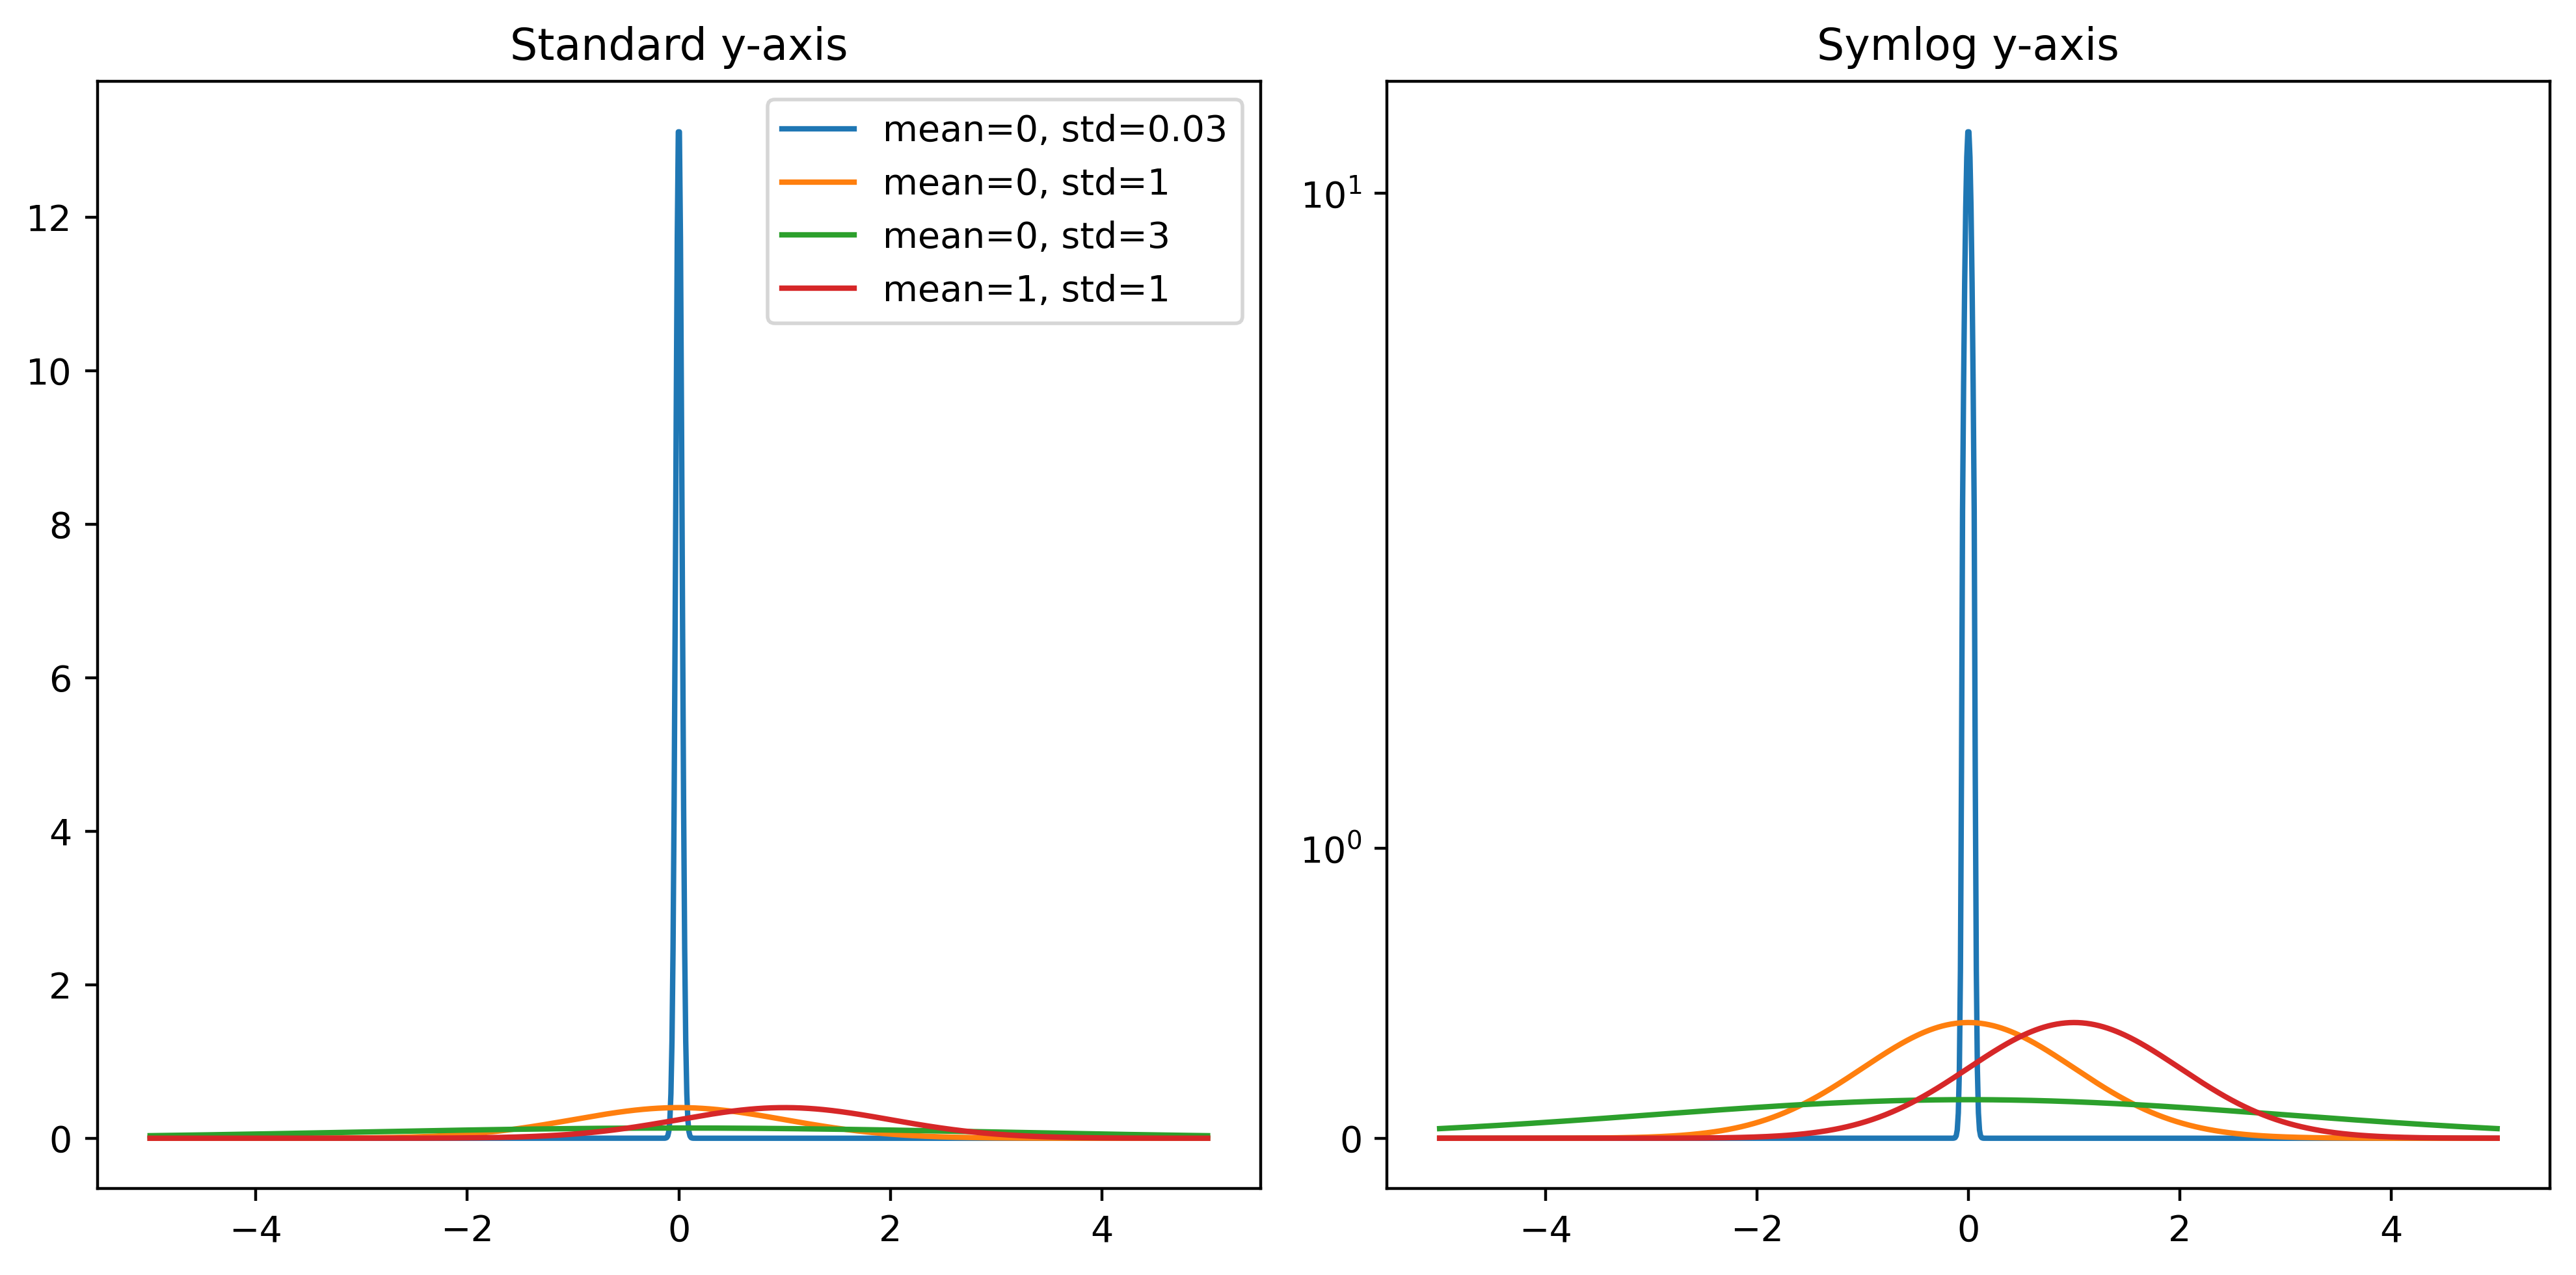

In [ ]:
# Let's make some plots in matplotlib to compare what Gaussian distributions look like
# with a standard y-axis and with a symlog y-axis. We'll compare the two plots with
# multiple variances and means

import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=400, sharex=True)

means = [0, 0, 0, 1]
stds = [0.03, 1, 3, 1]
x = np.linspace(-5, 5, 1000)
pdf = lambda x, mean, std: 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2) )

for mean, std in zip(means, stds):
    axs[0].plot(x, pdf(x, mean, std), label=f'mean={mean}, std={std}')
    axs[1].plot(x, pdf(x, mean, std), label=f'mean={mean}, std={std}')

axs[0].set_title('Standard y-axis')
axs[1].set_title('Symlog y-axis')
axs[1].set_yscale('symlog')
axs[0].legend()

fig.tight_layout()
fig.show()
